# Model 4



In [1]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib import rcParams, font_manager
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from geopy.distance import geodesic
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs


In [2]:

# # Path to the "Regular" style of CMU Typewriter Text
font_path = '/System/Library/Fonts/HelveticaNeue.ttc'  # Regular style
cmvtt_font = font_manager.FontProperties(fname=font_path)

# Set the font globally
rcParams['font.family'] = cmvtt_font.get_name()

## Defining Uncertainty in measurement

In [3]:

# Define uncertainty levels (as a fraction of the mean value)
uncertainty_levels = {
    'concentration': 0.1,  # 10% uncertainty
    'Cl_rain': 0.1,  # 10% uncertainty in rain Cl concentration
    'X_rain': 0.1,  # 10% uncertainty in rain elemental ratios
    'X_Cl_ratios': 0.1,  # 10% uncertainty in X/Cl ratios
    'Elevation': 0.001,  # 0.1% uncertainty in Elevation
    'C_0': 0.1,  # 10% uncertainty in initial concentration C_0
    'C_eq': 0.1,  # 10% uncertainty in equilibrium concentration C_eq
    'A_a': 0.1,  # 10% uncertainty in specific surface area
    'X_r': 0.1,  # 10% uncertainty in mineral concentration
    'rho_sf': 0.1,  # 10% uncertainty in mineral/fluid volume ratio
    'k': 0.1,  # 10% uncertainty in reaction rate
    'f': 0.1,  # 10% uncertainty in f factor
    'S': 0.1,  # 10% uncertainty in specific surface area for Fontorbe model
    'rho_plag': 0.1,  # 10% uncertainty in density for Fontorbe model
    'phi': 0.1,  # 10% uncertainty in porosity for Fontorbe model
    'T': 0.1,  # 10% uncertainty in temperature
    'R': 0,  # 10% uncertainty in gas constant
    'ln_k': 0.1  # 10% uncertainty in natural logarithm of reaction rate
}


# Correction

In [4]:
# df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Trav_3_data_Final.xlsx')

# df_copy = df.copy()

# df_trav1 = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/model4_full.xlsx')

# df_2 = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/model4_full.xlsx')

# df_full = df_2.copy()

In [5]:
df_uncorrected = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/NMS_Copy_080125.xlsx', sheet_name='Final_compiled')

df_rain = df_uncorrected[df_uncorrected['Sample type'] == 'Rain']    

df_uncorrected_copy = df_uncorrected.copy() 

df_uncorrected_copy = df_uncorrected_copy[df_uncorrected_copy['Sample type'].isin(['Spring', 'Spring water', 'Groundwater'])] 


In [6]:
# Convert concentrations from ppm to mM
df_rain['Ca_mM'] = df_rain['Ca_ppm'] / 40.08
df_rain['Mg_mM'] = df_rain['Mg_ppm'] / 24.31
df_rain['Si_mM'] = df_rain['Si_ppm'] / 28.09
df_rain['Na_mM'] = df_rain['Na_ppm'] / 22.99
df_rain['Li_mM'] = df_rain['Li_ppm'] / 6.94
df_rain['K_mM'] = df_rain['K_ppm'] / 39.10
df_rain['Al_mM'] = df_rain['Al_ppm'] / 26.98
df_rain['Li_uM'] = df_rain['Li_mM'] * 1000
df_rain['Sr_mM'] = df_rain['Sr_ppm'] / 87.62



# Convert Cl from molar to mM
df_rain['Cl_mM'] = df_rain['Cl_molar'] / 1000



# Calculate ion ratios
df_rain['Na/Ca'] = df_rain['Na_mM'] / df_rain['Ca_mM']
df_rain['Ca/Na'] = df_rain['Ca_mM'] / df_rain['Na_mM']
df_rain['Mg/Ca'] = df_rain['Mg_mM'] / df_rain['Ca_mM']
df_rain['Mg/Na'] = df_rain['Mg_mM'] / df_rain['Na_mM']
df_rain['Ca/Sr'] = df_rain['Ca_mM'] / df_rain['Sr_mM']
df_rain['1000xSr/Ca'] = df_rain['Sr_mM'] / df_rain['Ca_mM'] * 1000
df_rain['Si/Ca'] = df_rain['Si_mM'] / df_rain['Ca_mM']

/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/996095350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rain['Ca_mM'] = df_rain['Ca_ppm'] / 40.08
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/996095350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rain['Mg_mM'] = df_rain['Mg_ppm'] / 24.31
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/996095350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [7]:
# Convert concentrations from ppm to mM
df_uncorrected_copy['Ca_mM'] = df_uncorrected_copy['Ca_ppm'] / 40.08
df_uncorrected_copy['Sr_mM'] = df_uncorrected_copy['Sr_ppm'] / 87.62
df_uncorrected_copy['Mg_mM'] = df_uncorrected_copy['Mg_ppm'] / 24.31
df_uncorrected_copy['Si_mM'] = df_uncorrected_copy['Si_ppm'] / 28.09
df_uncorrected_copy['Na_mM'] = df_uncorrected_copy['Na_ppm'] / 22.99
df_uncorrected_copy['Li_mM'] = df_uncorrected_copy['Li_ppm'] / 6.94
df_uncorrected_copy['K_mM'] = df_uncorrected_copy['K_ppm'] / 39.10
df_uncorrected_copy['Al_mM'] = df_uncorrected_copy['Al_ppm'] / 26.98
df_uncorrected_copy['Li_uM'] = df_uncorrected_copy['Li_mM'] * 1000
# Convert Cl from molar to mM
df_uncorrected_copy['Cl_mM'] = df_uncorrected_copy['Cl_molar'] / 1000

# Calculate ion ratios
df_uncorrected_copy['Na/Ca'] = df_uncorrected_copy['Na_mM'] / df_uncorrected_copy['Ca_mM']
df_uncorrected_copy['Ca/Na'] = df_uncorrected_copy['Ca_mM'] / df_uncorrected_copy['Na_mM']
df_uncorrected_copy['Mg/Ca'] = df_uncorrected_copy['Mg_mM'] / df_uncorrected_copy['Ca_mM']
df_uncorrected_copy['Mg/Na'] = df_uncorrected_copy['Mg_mM'] / df_uncorrected_copy['Na_mM']
df_uncorrected_copy['Ca/Sr'] = df_uncorrected_copy['Ca_mM'] / df_uncorrected_copy['Sr_mM']
df_uncorrected_copy['1000xSr/Ca'] = df_uncorrected_copy['Sr_mM'] / df_uncorrected_copy['Ca_mM'] * 1000
df_uncorrected_copy['Si/Ca'] = df_uncorrected_copy['Si_mM'] / df_uncorrected_copy['Ca_mM']


In [8]:
#filter df_rain to remove NaN values
df_rain = df_rain[df_rain['Cl_mM'].notna()]


#print df_rain Cl_mM and Sample ID next to each other
print(df_rain[['Cl_mM', 'Sample ID']])

#plot these on a folium map:
# Create a map centered on Nepal
m = folium.Map(location=[28.3949, 84.1240], zoom_start=7)

# Add points to the map
for idx, row in df_rain.iterrows():
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=row['Sample ID']).add_to(m)
    
# Display the map
m.save('map.html')
webbrowser.open('map.html')


        Cl_mM  Sample ID
232  0.010560  Nep24-008
236  0.001369  Nep24-012
254  0.000565  Nep24-030
259  0.001343  Nep24-035
260  0.007334  Nep24-036
261  0.001420  Nep24-037
263  0.028087  NEP24-039
267  0.003551  NEP24-043
268  0.001887  NEP24-044
269  0.003213  NEP24-045
270  0.002858  NEP24-046
271  0.000548  NEP24-047
272  0.003646  NEP24-048
277  0.001485  NEP24-053
278  0.006508  NEP24-054
279  0.000257  NEP24-055
281  0.005841  NEP24-057
282  0.000809  NEP24-058
283  0.032024  NEP24-059
284  0.008690  NEP24-060


True

In [9]:
def assign_traverse(gns):
    if not isinstance(gns, str):  # Handle non-string values
        return None

    # Normalize the GNS by stripping suffixes and quotes
    gns = gns.split('22')[0].split('23')[0].strip("'").strip('"')
    
    # S1 group
    if gns.startswith("S1"):
        if gns in ["S1m", "S1i"]:  # Special cases for Traverse 1*
            return "Traverse 1*"
        return "Traverse 1"
    # S2 group
    elif gns.startswith("S2"):
        return "Traverse 2"
    # S3 group
    elif gns.startswith("S3"):
        if gns in ["S3k", "S3m", "S3u", "S3s", "S3ag", "S3ad"]:  # Special cases for Traverse 4
            return "Traverse 4"
        elif gns in ["S3y", "S3ae"]:  # Special cases for Traverse 3*
            return "Traverse 3*"
        return "Traverse 3"  # Default case for S3
    # S4 group
    elif gns.startswith("S4"):
        if gns in ["S4m", "S4l"]:  # Special cases for Traverse 5*
            return "Traverse 5*"
        return "Traverse 5"
    # Default case for unknown values
    return None



# Apply the function to create the new column
df_uncorrected_copy["Traverse"] = df_uncorrected_copy["GNS"].apply(assign_traverse)




In [10]:
#print(df_rain['Traverse'])  
# print Site A, B, C, D, E sample Ids for df_rain
df_rain_siteA = df_rain[df_rain['Traverse'] == 'Site A']
df_rain_siteB = df_rain[df_rain['Traverse'] == 'Site B']
df_rain_siteC = df_rain[df_rain['Traverse'] == 'Site C']
df_rain_siteD = df_rain[df_rain['Traverse'] == 'Site D']
df_rain_siteE = df_rain[df_rain['Traverse'] == 'Site E']

sites = ['Site A', 'Site B', 'Site C', 'Site D', 'Site E']


In [11]:
element_dict = ['Ca', 'Sr', 'Mg', 'Si', 'Na', 'Li', 'K', 'Al', 'Cl']


# Compute site-specific rain averages
site_means = {}
for site in sites:
    site_rain = df_rain[df_rain['Traverse'] == site]
    if not site_rain.empty:  # Only add sites with data
        site_means[site] = {
            'Cl_mM': site_rain['Cl_mM'].mean(),
            **{f'{element}_mM': site_rain[f'{element}_mM'].mean() for element in element_dict}
        }


In [12]:
# Sites C, D, E
sites = ['Site A', 'Site B', 'Site C', 'Site D', 'Site E']

# Convert ppm to mM and store site-specific rain averages
for element in element_dict:
    df_rain[f'{element}_mM'] = df_rain[f'{element}_ppm'] / {'Ca': 40.08, 'Sr': 87.62, 'Mg': 24.31, 'Si': 28.09, 'Na': 22.99, 'Li': 6.94, 'K': 39.10, 'Al': 26.98, 'Cl': 35.453}[element]

# Compute site-specific rain averages
site_means = {}
for site in sites:
    site_rain = df_rain[df_rain['Traverse'] == site]
    if not site_rain.empty:  # Only add sites with data
        site_means[site] = {
            'Cl_mM': site_rain['Cl_mM'].mean(),
            **{f'{element}_mM': site_rain[f'{element}_mM'].mean() for element in element_dict}
        }


# Define function to calculate the closest rain site
def find_closest_site(row, df_rain):
    sample_coords = (row['Latitude'], row['Longitude'])
    df_rain['Distance'] = df_rain.apply(lambda rain_row: geodesic(sample_coords, (rain_row['Latitude'], rain_row['Longitude'])).kilometers, axis=1)
    closest_site = df_rain.loc[df_rain['Distance'].idxmin(), 'Traverse']
    return closest_site

# Add closest site information to df_uncorrected_copy
df_uncorrected_copy['Closest_Site'] = df_uncorrected_copy.apply(find_closest_site, axis=1, df_rain=df_rain)

# Define function to calculate rain correction
def rain_correction(row, site_means, element_dict):
    closest_site = row['Closest_Site']
    if closest_site not in site_means:
        raise ValueError(f"Closest site '{closest_site}' not found in site_means.")

    site_data = site_means[closest_site]
    corrected_values = {}
    for element in element_dict:
        Cl_river = row['Cl_mM']
        Cl_rain = site_data['Cl_mM']
        X_rain = site_data[f'{element}_mM']

        # Calculate Cl_river_star
        Cl_river_star = max(Cl_river - Cl_rain, 0)

        # Calculate X_corrected
        X_corrected = row[f'{element}_mM'] - (Cl_river - Cl_river_star) * (X_rain / Cl_rain)
        corrected_values[f'{element}_mM_*'] = X_corrected

    return pd.Series(corrected_values)


# Apply rain correction
df_corrected = df_uncorrected_copy.apply(rain_correction, axis=1, site_means=site_means, element_dict=element_dict)

# Merge corrected values back into df_copy
df_corrected_copy = pd.concat([df_uncorrected_copy, df_corrected], axis=1)

print(df_corrected_copy)

     Sample ID    GNS  Season       Date      Time   Sample type  \
33     MKS 10B  S2a19  Nov_18        NaT       NaN  Spring water   
34     MKS 11B    NaN  Nov_18        NaT       NaN  Spring water   
35     MKS 15B  S4d19  Nov_18        NaT       NaN  Spring water   
36     MKS 18B  S4k19  Nov_18        NaT       NaN  Spring water   
37      MKS 1B  S1m19  Nov_18        NaT       NaN  Spring water   
..         ...    ...     ...        ...       ...           ...   
288  NEP24-064  S2g24  Sep_24 2024-09-16  12:31:54        Spring   
289  NEP24-065  S2f24  Sep_24 2024-09-16  13:26:04        Spring   
290  NEP24-066  S2e24  Sep_24 2024-09-16  14:08:27        Spring   
291  NEP24-067  S2c24  Sep_24 2024-09-16  15:00:54        Spring   
292  NEP24-068  S2a24  Sep_24 2024-09-16  15:34:44        Spring   

    Repeat_collection                                       Site_details  \
33                NaN                                          Abra-2019   
34                NaN          

In [13]:
# Order samples by Cl_mM_* in descending order
ordered_samples = df_corrected_copy.sort_values('Cl_mM_*', ascending=False)

# Find a valid sample where all required X/Cl ratios can be computed
X_Cl_ratios = {}
for _, sample in ordered_samples.iterrows():
    is_valid = True
    ratios = {}
    for element in element_dict:
        # Check for valid Cl and element_mM_* values
        if sample['Cl_mM_*'] > 0 and not pd.isna(sample[f'{element}_mM_*']):
            ratios[element] = sample[f'{element}_mM_*'] / sample['Cl_mM_*']
        else:
            is_valid = False
            break  # If any value is invalid, skip this sample
    
    if is_valid:
        X_Cl_ratios = ratios
        break  # Stop as soon as a valid sample is found

# If no valid sample is found, raise an error or handle it gracefully
if not X_Cl_ratios:
    raise ValueError("No valid sample found for X/Cl ratio calculation.")

print("X/Cl Ratios:", X_Cl_ratios)

# Define the new correction function
def evaporite_correction(row, element_dict, X_Cl_ratios):
    evaporite_corrected_values = {}
    for element in element_dict:
        # Perform the evaporite correction
        X_corrected = row[f'{element}_mM_*']
        Cl_corrected = row['Cl_mM_*']
        X_evaporite_corrected = X_corrected - (X_Cl_ratios[element] * Cl_corrected)
        evaporite_corrected_values[f'{element}_mM_EC'] = X_evaporite_corrected

    return pd.Series(evaporite_corrected_values)

# Apply the evaporite correction
df_evaporite_corrected = df_corrected_copy.apply(evaporite_correction, axis=1, element_dict=element_dict, X_Cl_ratios=X_Cl_ratios)

# Merge evaporite-corrected values back into df_copy
df_corrected_copy = pd.concat([df_corrected_copy, df_evaporite_corrected], axis=1)


X/Cl Ratios: {'Ca': 0.41735569444323306, 'Sr': 0.0015173814010333803, 'Mg': 0.2918610003523339, 'Si': 0.7021082530031759, 'Na': 0.6975619929339737, 'Li': 4.148506057103098e-05, 'K': 0.1447739947492531, 'Al': 0.0001898854392169677, 'Cl': 1.0}


Monte Carlo simulation completed with N = 1000, including Elevation uncertainty.


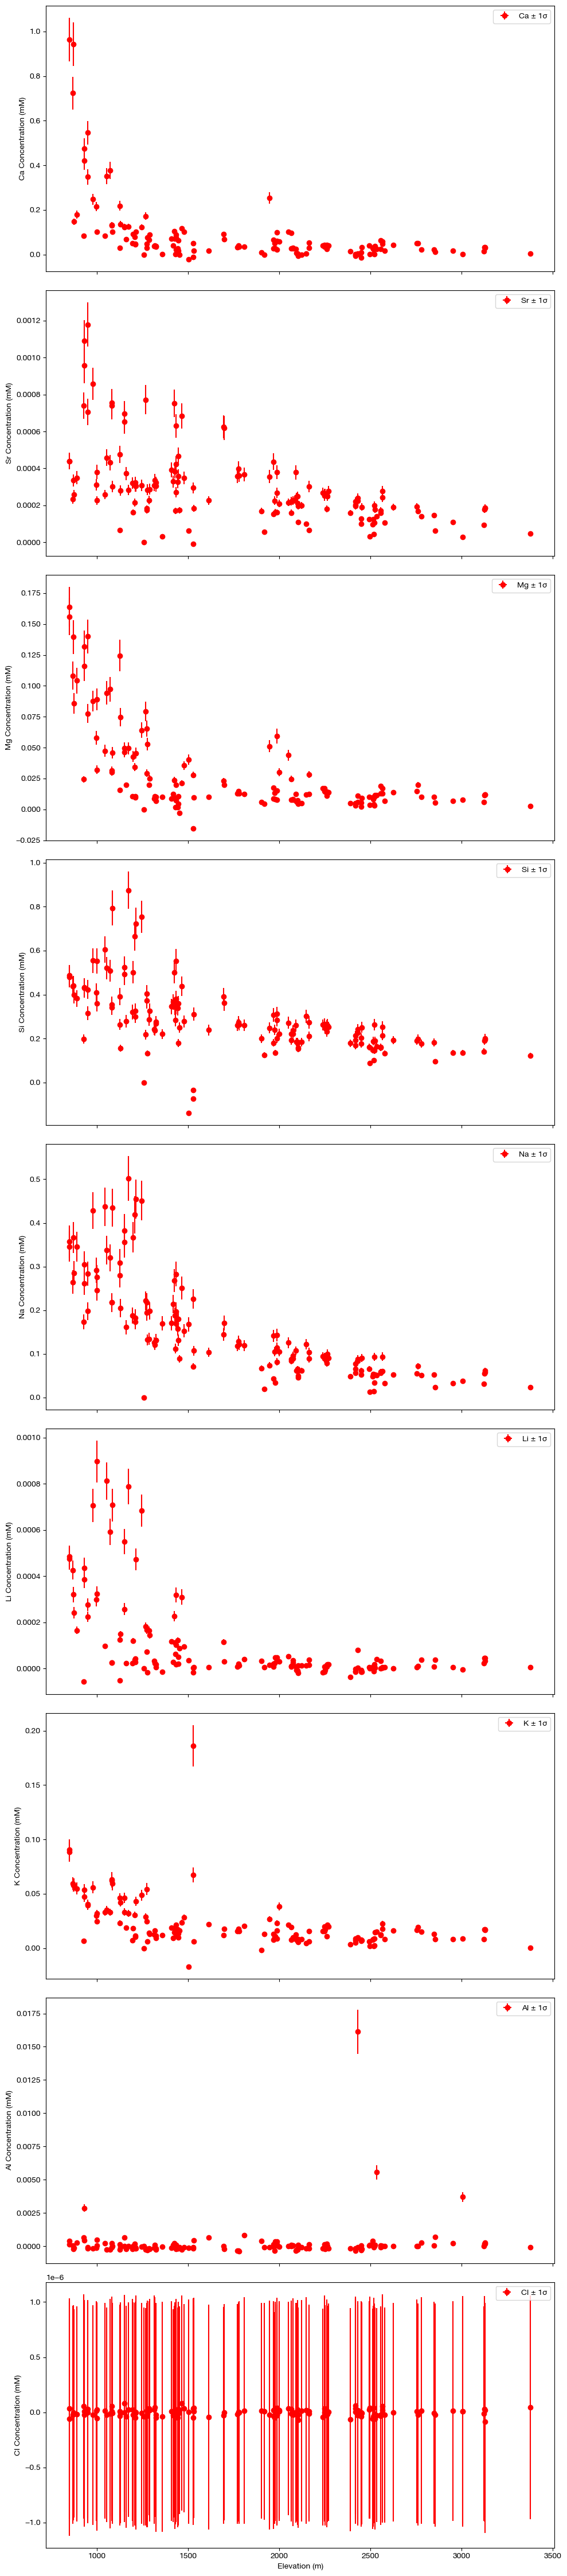

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Number of Monte Carlo simulations
N_simulations = 1000

# Initialize list for storing Monte Carlo realizations
monte_carlo_results = []


# Run Monte Carlo simulations
for i in range(N_simulations):
    df_sim = df_corrected_copy.copy()
    
    # Apply uncertainty after rain correction
    for element in element_dict:
        col_name = f"{element}_mM_*"
        uncertainty = np.nan_to_num(df_sim[col_name] * uncertainty_levels['concentration'], nan=0.0)
        uncertainty = np.where(uncertainty <= 0, 1e-6, uncertainty)  # Ensure non-negative uncertainty
        df_sim[col_name] += np.random.normal(0, uncertainty, size=len(df_sim))
    
    # Apply uncertainty after evaporite correction
    for element in element_dict:
        col_name = f"{element}_mM_EC"
        uncertainty = np.nan_to_num(df_sim[col_name] * uncertainty_levels['concentration'], nan=0.0)
        uncertainty = np.where(uncertainty <= 0, 1e-6, uncertainty)  # Ensure non-negative uncertainty
        df_sim[col_name] += np.random.normal(0, uncertainty, size=len(df_sim))
    
    # Apply uncertainty to Elevation
    elevation_uncertainty = np.nan_to_num(df_sim['Elevation'] * uncertainty_levels['Elevation'], nan=0.0)
    elevation_uncertainty = np.where(elevation_uncertainty <= 0, 1e-6, elevation_uncertainty)
    df_sim['Elevation'] += np.random.normal(0, elevation_uncertainty, size=len(df_sim))
    
    # Store the result
    monte_carlo_results.append(df_sim)

# Combine all simulations into a single DataFrame
df_monte_carlo = pd.concat(monte_carlo_results, keys=range(N_simulations), names=["Simulation", "Index"])

# Select only numeric columns for aggregation
numeric_cols = df_monte_carlo.select_dtypes(include=[np.number]).columns
df_monte_carlo_summary = df_monte_carlo[numeric_cols].groupby("Index").agg(["mean", "std"])

print("Monte Carlo simulation completed with N = 1000, including Elevation uncertainty.")

# Plot evaporite-corrected values with uncertainties against elevation
fig, axs = plt.subplots(len(element_dict), 1, figsize=(10, len(element_dict) * 5), sharex=True)
for i, element in enumerate(element_dict):
    ax = axs[i]
    mean_values = df_monte_carlo_summary[(f"{element}_mM_EC", "mean")]
    std_values = df_monte_carlo_summary[(f"{element}_mM_EC", "std")]
    elevation_mean = df_monte_carlo_summary[("Elevation", "mean")]
    elevation_std = df_monte_carlo_summary[("Elevation", "std")]
    ax.errorbar(elevation_mean, mean_values, xerr=elevation_std, yerr=std_values, fmt='o', color='red', label=f'{element} ± 1σ')
    ax.set_ylabel(f'{element} Concentration (mM)')
    ax.legend()
axs[-1].set_xlabel('Elevation (m)')
plt.tight_layout()
plt.show()

In [15]:
# set negative values in df_corrected_copy of the elements _mM_EC to NaN
df_corrected_copy.loc[df_corrected_copy['Ca_mM_EC'] < 0, 'Ca_mM_EC'] = np.nan
df_corrected_copy.loc[df_corrected_copy['Sr_mM_EC'] < 0, 'Sr_mM_EC'] = np.nan
df_corrected_copy.loc[df_corrected_copy['Mg_mM_EC'] < 0, 'Mg_mM_EC'] = np.nan
df_corrected_copy.loc[df_corrected_copy['Si_mM_EC'] < 0, 'Si_mM_EC'] = np.nan
df_corrected_copy.loc[df_corrected_copy['Na_mM_EC'] < 0, 'Na_mM_EC'] = np.nan
df_corrected_copy.loc[df_corrected_copy['Li_mM_EC'] < 0, 'Li_mM_EC'] = np.nan
df_corrected_copy.loc[df_corrected_copy['K_mM_EC'] < 0, 'K_mM_EC'] = np.nan
df_corrected_copy.loc[df_corrected_copy['Al_mM_EC'] < 0, 'Al_mM_EC'] = np.nan
df_corrected_copy.loc[df_corrected_copy['Cl_mM_EC'] < 0, 'Cl_mM_EC'] = np.nan


In [16]:

# Filter the DataFrame to include only rows where 'Cl_mM' is not NaN
df_corrected_copy = df_corrected_copy[df_corrected_copy['Cl_molar'].notna()]

# Create a figure and axes for the plots
fig, axs = plt.subplots(len(element_dict), 1, figsize=(10, len(element_dict) * 5), sharex=True)

# Loop through each element and create a scatter plot
for i, element in enumerate(element_dict):
    ax = axs[i]
    ax.scatter(df_corrected_copy['Elevation'], df_corrected_copy[f'{element}_mM'], label=f'{element}_INITIAL', color='blue')
    ax.scatter(df_corrected_copy['Elevation'], df_corrected_copy[f'{element}_mM_EC'], label=f'{element}_CORRECTED', color='red')
    ax.set_ylabel(f'{element} Concentration (mM)')
    ax.legend()

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('Elevation (m)')

# Adjust layout and display the plot
plt.tight_layout()
#plt.show()
plt.close()


# Post Correction

In [17]:
# define an element dictionary
from scipy.spatial import cKDTree

elements = {'Na_mM_EC', 'Ca_mM_EC', 'Mg_mM_EC', 'Si_mM_EC', 'K_mM_EC', 'Al_mM_EC', 'Sr_mM_EC'}

# make copies of elements Na_uM_EC etc

# Convert to μM and save as new columns
for elem in elements:
    new_col = elem.replace('_mM_', '_uM_')  # Replace 'mM' with 'uM' in the column name
    df_corrected_copy[new_col] = df_corrected_copy[elem] * 1000  # Convert mM to μM
    # df_full[new_col] = df_full[elem] * 1000  # Convert mM to μM
    # df_trav1[new_col] = df_trav1[elem] * 1000  # Convert mM to μM


elements_micro = {'Na_uM_EC', 'Ca_uM_EC', 'Mg_uM_EC', 'Si_uM_EC', 'K_uM_EC', 'Al_uM_EC', 'Sr_uM_EC'}



df_traverse1 = df_corrected_copy[df_corrected_copy['Traverse'] == 'Traverse 1']
df_traverse2 = df_corrected_copy[df_corrected_copy['Traverse'] == 'Traverse 2']
df_traverse3 = df_corrected_copy[df_corrected_copy['Traverse'] == 'Traverse 3']
df_traverse4 = df_corrected_copy[df_corrected_copy['Traverse'] == 'Traverse 4']
df_traverse5 = df_corrected_copy[df_corrected_copy['Traverse'] == 'Traverse 5']


# Calculate C_eq as the maximum concentration for each element in df_traverse3
C_0 = {element: df_traverse1[element].min() for element in elements_micro}
C_0 = {element: df_traverse2[element].min() for element in elements_micro}
C_0 = {element: df_traverse3[element].min() for element in elements_micro}
C_0 = {element: df_traverse4[element].min() for element in elements_micro}
C_0 = {element: df_traverse5[element].min() for element in elements_micro}

for element in elements_micro:
    df_traverse1[f'C_0_{element}'] = C_0[element]
    df_traverse2[f'C_0_{element}'] = C_0[element]
    df_traverse3[f'C_0_{element}'] = C_0[element]
    df_traverse4[f'C_0_{element}'] = C_0[element]
    df_traverse5[f'C_0_{element}'] = C_0[element]
    
    


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/2764976285.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f'C_0_{element}'] = C_0[element]
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/2764976285.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse2[f'C_0_{element}'] = C_0[element]
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/2764976285.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [18]:
# Calculate C_eq as the maximum concentration for each element in df_traverse3
C_eq = {element: df_corrected_copy[element].max() for element in elements_micro}

for element in elements_micro:
    df_traverse1[f'C_eq_{element}'] = C_eq[element]
    df_traverse2[f'C_eq_{element}'] = C_eq[element]
    df_traverse3[f'C_eq_{element}'] = C_eq[element]
    df_traverse4[f'C_eq_{element}'] = C_eq[element]
    df_traverse5[f'C_eq_{element}'] = C_eq[element]
    

# print the first 5 rows of C_eq_element
print(df_traverse3[[f'C_eq_{element}' for element in elements_micro]].head())



    C_eq_K_uM_EC  C_eq_Ca_uM_EC  C_eq_Si_uM_EC  C_eq_Na_uM_EC  C_eq_Sr_uM_EC  \
41    185.855325     960.514077     869.214435      501.88711       1.177916   
42    185.855325     960.514077     869.214435      501.88711       1.177916   
43    185.855325     960.514077     869.214435      501.88711       1.177916   
47    185.855325     960.514077     869.214435      501.88711       1.177916   
48    185.855325     960.514077     869.214435      501.88711       1.177916   

    C_eq_Al_uM_EC  C_eq_Mg_uM_EC  
41      16.204954     163.835453  
42      16.204954     163.835453  
43      16.204954     163.835453  
47      16.204954     163.835453  
48      16.204954     163.835453  


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/499439028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f'C_eq_{element}'] = C_eq[element]
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/499439028.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse2[f'C_eq_{element}'] = C_eq[element]
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/499439028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [19]:
# Monte Carlo Now

# Convert Monte Carlo summary concentrations to μM
for elem in elements:
    micro_col_mean = (elem.replace('_mM_', '_uM_'), 'mean')
    micro_col_std = (elem.replace('_mM_', '_uM_'), 'std')
    df_monte_carlo_summary[micro_col_mean] = df_monte_carlo_summary[(elem, 'mean')] * 1000
    df_monte_carlo_summary[micro_col_std] = df_monte_carlo_summary[(elem, 'std')] * 1000

/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/3197216115.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_monte_carlo_summary[micro_col_std] = df_monte_carlo_summary[(elem, 'std')] * 1000
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/3197216115.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_monte_carlo_summary[micro_col_mean] = df_monte_carlo_summary[(elem, 'mean')] * 1000
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/3197216115.py:8: PerformanceWarning: Data

In [20]:
# Store simulated traverse datasets
simulated_traverses = {}

for i in range(N_simulations):
    df_sim = df_monte_carlo.loc[i].copy()  # Use existing Monte Carlo results
    
    # Apply uncertainty to C_0 and C_eq
    for element in elements_micro:
        df_sim[f'C_0_{element}'] = C_0[element] * np.random.normal(1, uncertainty_levels['C_0'], size=len(df_sim))
        df_sim[f'C_eq_{element}'] = C_eq[element] * np.random.normal(1, uncertainty_levels['C_eq'], size=len(df_sim))
    
    # Store updated traverse datasets
    for traverse_name, df_traverse in zip(['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 4', 'Traverse 5'],
                                           [df_traverse1, df_traverse2, df_traverse3, df_traverse4, df_traverse5]):
        simulated_traverses[traverse_name] = df_sim[df_sim['Traverse'] == traverse_name]
    
    monte_carlo_results.append(df_sim)

# Combine all simulations into a single DataFrame
df_monte_carlo = pd.concat(monte_carlo_results, keys=range(N_simulations), names=["Simulation", "Index"])

# Select only numeric columns for aggregation
numeric_cols = df_monte_carlo.select_dtypes(include=[np.number]).columns
df_monte_carlo_summary = df_monte_carlo[numeric_cols].groupby("Index").agg(["mean", "std"])


In [21]:
# Print simulated C_0 and C_eq for each traverse
print("Simulated C_0 and C_eq values for each traverse:")
for traverse_name, df_sim_traverse in simulated_traverses.items():
    print(f"\n{traverse_name}:")
    for element in elements_micro:
        print(f"{element}: C_0 = {df_sim_traverse[f'C_0_{element}'].mean():.3f} ± {df_sim_traverse[f'C_0_{element}'].std():.3f}, "
              f"C_eq = {df_sim_traverse[f'C_eq_{element}'].mean():.3f} ± {df_sim_traverse[f'C_eq_{element}'].std():.3f}")


Simulated C_0 and C_eq values for each traverse:

Traverse 1:
K_uM_EC: C_0 = 0.576 ± 0.064, C_eq = 186.541 ± 19.077
Ca_uM_EC: C_0 = 1.544 ± 0.168, C_eq = 974.668 ± 100.083
Si_uM_EC: C_0 = 93.886 ± 9.179, C_eq = 873.315 ± 92.410
Na_uM_EC: C_0 = 23.277 ± 2.713, C_eq = 495.573 ± 52.642
Sr_uM_EC: C_0 = 0.031 ± 0.003, C_eq = 1.185 ± 0.105
Al_uM_EC: C_0 = 0.003 ± 0.000, C_eq = 16.064 ± 1.943
Mg_uM_EC: C_0 = 2.586 ± 0.278, C_eq = 162.435 ± 15.029

Traverse 2:
K_uM_EC: C_0 = 0.571 ± 0.054, C_eq = 188.436 ± 23.539
Ca_uM_EC: C_0 = 1.515 ± 0.156, C_eq = 965.810 ± 104.348
Si_uM_EC: C_0 = 94.180 ± 8.906, C_eq = 884.458 ± 88.694
Na_uM_EC: C_0 = 23.383 ± 2.824, C_eq = 505.789 ± 53.972
Sr_uM_EC: C_0 = 0.030 ± 0.003, C_eq = 1.164 ± 0.099
Al_uM_EC: C_0 = 0.003 ± 0.000, C_eq = 15.734 ± 1.483
Mg_uM_EC: C_0 = 2.504 ± 0.253, C_eq = 165.239 ± 15.668

Traverse 3:
K_uM_EC: C_0 = 0.556 ± 0.051, C_eq = 186.278 ± 17.521
Ca_uM_EC: C_0 = 1.561 ± 0.160, C_eq = 985.819 ± 99.556
Si_uM_EC: C_0 = 94.836 ± 10.822, C_eq =

# Maher


In [22]:
A_a = 0.1  # Specific surface area (m^2/g)

X_r = 0.2  # Mineral concentration in rock (unitless, g/g)

rho_sf = 2.7 * 1000 * 1000  # Mass mineral / fluid volume ratio (g/cm^3), assuming porosity = 0.1 [for now]

k = 10**(-15) # Reaction rate (mol/m^2/s)

R_n = rho_sf * A_a * k * X_r # Rate constant (mol/m^2/s)

f = 0.5

print(R_n)

5.4e-11


### Calculating it Generally

In [23]:
def calculate_T_res_Model4_Maher(C, C_0, C_eq, R_n):

    # how to write e**2 in python?
    e2 = np.exp(2)

    T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
    
    if isinstance(T_res, (list, tuple, np.ndarray)):
        T_res = T_res[0]  # Extract the first value if it's an array

    if not np.isscalar(T_res) or np.isnan(T_res):
        return np.nan  # Ensure we return a single number

    T_res_yr = T_res * 10**(-3) / 31557600 # Convert seconds to years
    
    
    return float(T_res_yr)  # Ensure it's a float


for i in range(1, 6):  # Loop through df_traverse1 to df_traverse5
    df_name = f"df_traverse{i}"  # Construct the variable name as a string
    df = globals()[df_name]  # Get the actual DataFrame object
    
    for element in elements_micro:
        col_name = f'T_res_Maher_{element}'
        df[col_name] = df.apply(
            lambda row: calculate_T_res_Model4_Maher(
                row[element], row[f'C_0_{element}'], row[f'C_eq_{element}'],
                R_n
            ), axis=1
        )


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/4167668192.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.apply(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/4167668192.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/4167668192.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.apply(
/var/fo

In [24]:


print("T_res Range for Each Element in Each DataFrame:")

for i in range(1, 6):  # Loop through df_traverse1 to df_traverse5
    df_name = f"df_traverse{i}"
    df = globals()[df_name]  # Get the actual DataFrame object

    print(f"\n### {df_name} ###")
    
    for element in elements_micro:
        col_name = f'T_res_Maher_{element}'
        
        # Drop NaNs and ensure the column is numeric
        T_res_series = pd.to_numeric(df[col_name], errors='coerce').dropna()
        
        # Remove values greater than 1000 years
        T_res_series = T_res_series[T_res_series < 1000]

        if not T_res_series.empty:
            T_res_min = T_res_series.min()
            T_res_max = T_res_series.max()
            print(f"Element: {element}, T_res range: {T_res_min:.2f} to {T_res_max:.2f} years")
        else:
            print(f"Element: {element}, No valid T_res values available")


T_res Range for Each Element in Each DataFrame:

### df_traverse1 ###
Element: K_uM_EC, T_res range: 0.52 to 14.06 years
Element: Ca_uM_EC, T_res range: 1.74 to 239.99 years
Element: Si_uM_EC, T_res range: 10.56 to 638.79 years
Element: Na_uM_EC, T_res range: 17.59 to 370.33 years
Element: Sr_uM_EC, T_res range: 0.00 to 0.17 years
Element: Al_uM_EC, T_res range: 0.00 to 0.05 years
Element: Mg_uM_EC, T_res range: 0.39 to 229.15 years

### df_traverse2 ###
Element: K_uM_EC, T_res range: 0.47 to 8.30 years
Element: Ca_uM_EC, T_res range: -0.12 to 100.98 years
Element: Si_uM_EC, T_res range: -7.55 to 101.02 years
Element: Na_uM_EC, T_res range: -1.85 to 218.32 years
Element: Sr_uM_EC, T_res range: -0.00 to 1.21 years
Element: Al_uM_EC, T_res range: -0.00 to 0.28 years
Element: Mg_uM_EC, T_res range: -0.08 to 73.69 years

### df_traverse3 ###
Element: K_uM_EC, T_res range: 0.10 to 2.60 years
Element: Ca_uM_EC, T_res range: -0.04 to 10.44 years
Element: Si_uM_EC, T_res range: -0.62 to 54.76 

/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/3283468684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse1[f"T_res_Maher_{element}"], errors='coerce')
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/3283468684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse2[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse2[f"T_res_Maher_{element}"], errors='coerce')
/var/folders/9m/bjwjgvv11dxfyfxc

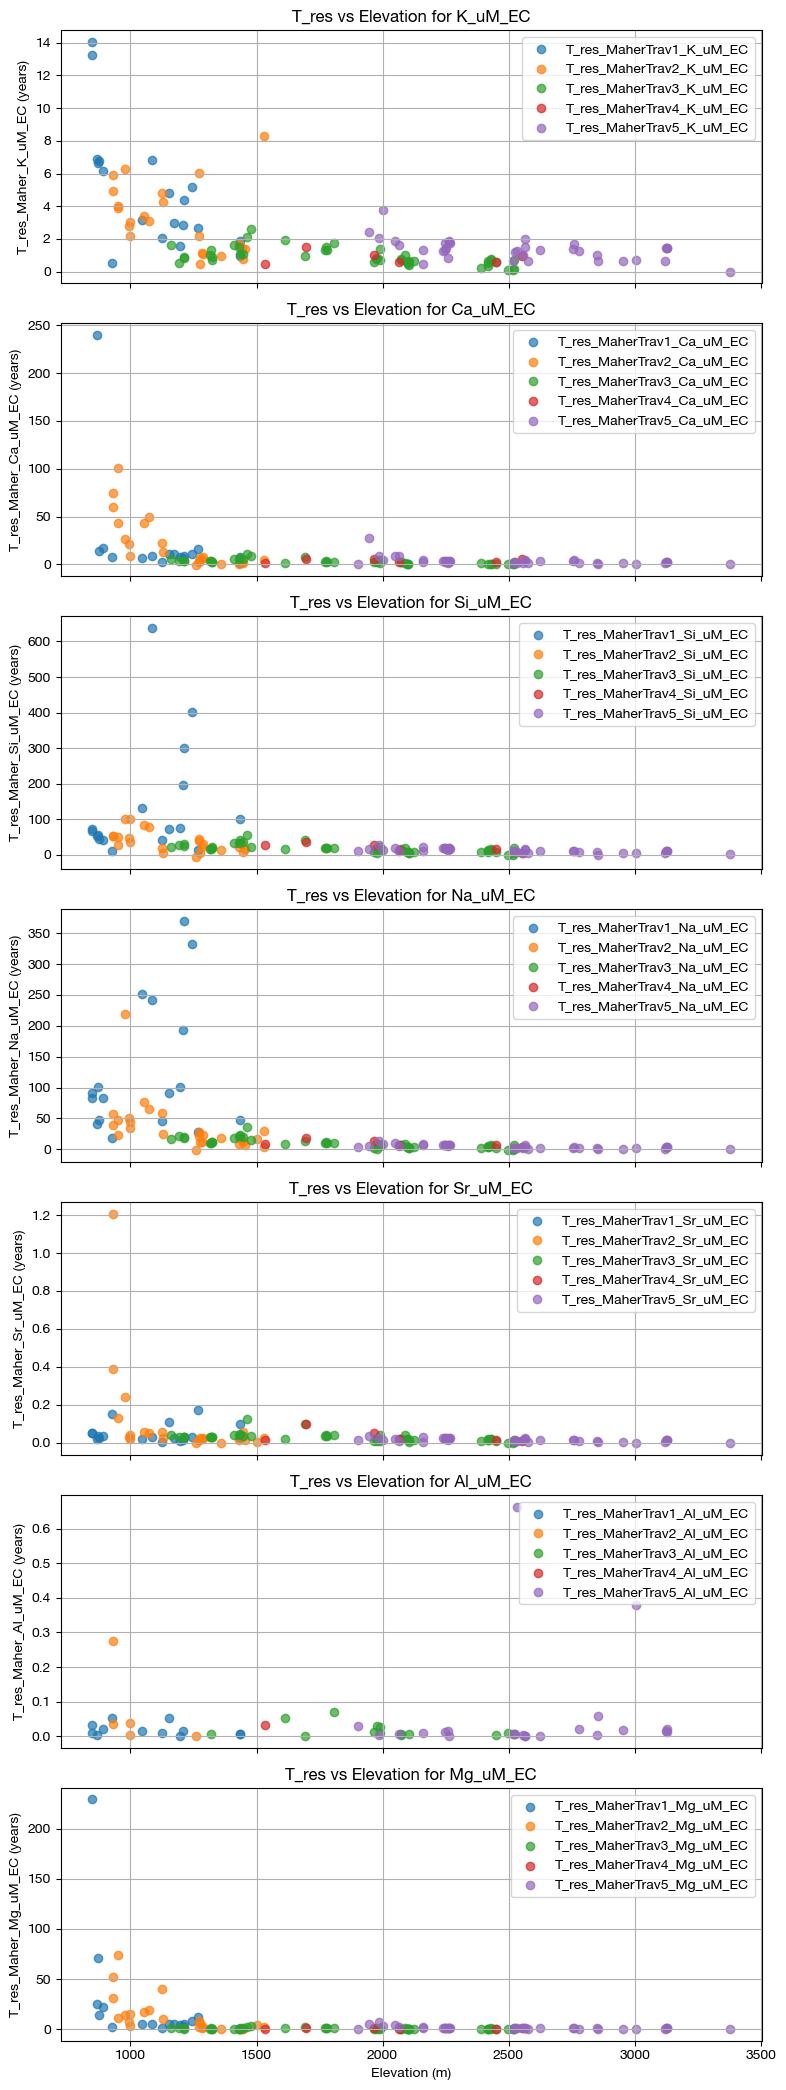

In [25]:
# Convert all T_res columns to numeric to avoid errors
for element in elements_micro:
    df_traverse1[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse1[f"T_res_Maher_{element}"], errors='coerce')
    df_traverse2[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse2[f"T_res_Maher_{element}"], errors='coerce')
    df_traverse3[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse3[f"T_res_Maher_{element}"], errors='coerce')
    df_traverse4[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse4[f"T_res_Maher_{element}"], errors='coerce')
    df_traverse5[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse5[f"T_res_Maher_{element}"], errors='coerce')



# Create a figure with subplots for each element
num_elements = len(elements_micro)
fig, axes = plt.subplots(nrows=num_elements, ncols=1, figsize=(8, num_elements * 3), sharex=True)

# If only one subplot, wrap it in a list for consistency
if num_elements == 1:
    axes = [axes]

# Loop over each element and plot in a separate subplot
for ax, element in zip(axes, elements_micro):
    for i in range(1, 6):  # Loop through df_traverse1 to df_traverse5
        df_name = f"df_traverse{i}"
        df = globals()[df_name]  # Get the DataFrame

        # Filter T_res values below 1000 years
        valid_data = df[df[f"T_res_Maher_{element}"] < 1000]

        # Plot scatter if data exists
        if not valid_data.empty:
            ax.scatter(
                valid_data["Elevation"], valid_data[f"T_res_Maher_{element}"],
                alpha=0.7, label=f"T_res_MaherTrav{i}_{element}"
            )

    ax.set_ylabel(f"T_res_Maher_{element} (years)")
    ax.set_title(f"T_res vs Elevation for {element}")
    ax.legend()
    ax.grid(True)

# Remove any unused subplots
for i in range(num_elements, len(axes)):
    fig.delaxes(axes[i])

# Set common x-axis label
axes[-1].set_xlabel("Elevation (m)")

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()

### Monte Carlo

In [26]:

# Store simulated traverse datasets
simulated_traverses = {}

# Ensure µM columns exist in df_monte_carlo and propagate uncertainty
for elem in elements:
    micro_col = elem.replace('_mM_', '_uM_')  # Convert 'mM' to 'uM'
    if micro_col not in df_monte_carlo.columns:
        df_monte_carlo[micro_col] = df_monte_carlo[elem] * 1000  # Convert from mM to µM
        
        # Propagate uncertainty for µM values
        uncertainty_col = f"{micro_col}_std"
        df_monte_carlo[uncertainty_col] = df_monte_carlo[elem] * 1000 * uncertainty_levels['concentration']


# Ensure C_0 and C_eq exist for µM columns in df_monte_carlo
for elem in elements_micro:
    c0_col = f'C_0_{elem}'
    ceq_col = f'C_eq_{elem}'
    
    if c0_col not in df_monte_carlo.columns:
        df_monte_carlo[c0_col] = df_monte_carlo[elem].min()  # Assign min value for C_0
    
    if ceq_col not in df_monte_carlo.columns:
        df_monte_carlo[ceq_col] = df_monte_carlo[elem].max()  # Assign max value for C_eq
    
    # Propagate uncertainty for C_0 and C_eq
    df_monte_carlo[f'{c0_col}_std'] = df_monte_carlo[c0_col] * uncertainty_levels['C_0']
    df_monte_carlo[f'{ceq_col}_std'] = df_monte_carlo[ceq_col] * uncertainty_levels['C_eq']

monte_carlo_results = []  # Ensure this list is fresh for storing results

for i in range(N_simulations):
    df_sim = df_monte_carlo.loc[i].copy()

    # Apply uncertainty to Maher model parameters
    A_a_sim = A_a * np.random.normal(1, uncertainty_levels['A_a'])
    X_r_sim = X_r * np.random.normal(1, uncertainty_levels['X_r'])
    rho_sf_sim = rho_sf * np.random.normal(1, uncertainty_levels['rho_sf'])
    k_sim = k * np.random.normal(1, uncertainty_levels['k'])
    f_sim = f * np.random.normal(1, uncertainty_levels['f'])

    R_n_sim = rho_sf_sim * A_a_sim * k_sim * X_r_sim  # Simulated rate constant

    # 🔍 Debugging: Check if df_sim initially contains T_res_Maher
   #print(f"🔎 Before computation: df_sim columns (Sim {i}): {df_sim.columns.tolist()}")

    # Compute residence time for each traverse separately
    for traverse_name in ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 4', 'Traverse 5']:
        df_traverse_sim = df_sim[df_sim['Traverse'] == traverse_name].copy()

        if df_traverse_sim.empty:
            continue  # Skip empty traverses

        for element in elements_micro:
            if element in df_traverse_sim.columns:
                df_traverse_sim[f'T_res_Maher_{element}'] = df_traverse_sim.apply(
                    lambda row: calculate_T_res_Model4_Maher(
                        row[element], row[f'C_0_{element}'], row[f'C_eq_{element}'], R_n_sim
                    ), axis=1
                )

                # ✅ Store computed values directly into `df_sim`
                df_sim.loc[df_traverse_sim.index, f'T_res_Maher_{element}'] = df_traverse_sim[f'T_res_Maher_{element}']

                # 🔍 Debugging: Print some computed values
                #print(f"✅ Sim {i}, {traverse_name}, {element}: Min={df_traverse_sim[f'T_res_Maher_{element}'].min()}, Max={df_traverse_sim[f'T_res_Maher_{element}'].max()}")

        simulated_traverses.setdefault(traverse_name, []).append(df_traverse_sim)

    # 🔍 Debugging: Check if df_sim contains T_res_Maher before appending
    #print(f"🔎 After computation: df_sim columns (Sim {i}): {df_sim.columns.tolist()}")

    # ✅ Append df_sim (now containing computed T_res_Maher values) to monte_carlo_results
    monte_carlo_results.append(df_sim)




# ✅ Now, df_monte_carlo will have T_res_Maher values for aggregation
df_monte_carlo = pd.concat(monte_carlo_results, keys=range(N_simulations), names=["Simulation", "Index"])

# Select only numeric columns for aggregation
numeric_cols = df_monte_carlo.select_dtypes(include=[np.number]).columns
if numeric_cols.any():
    df_monte_carlo_summary = df_monte_carlo[numeric_cols].groupby("Index").agg(["mean", "std"])



/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/4167668192.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/4167668192.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/4167668192.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/4167668192.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/4167668192.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
/var/folders/9m

In [27]:
# Combine all simulations into a single DataFrame
df_monte_carlo = pd.concat(monte_carlo_results, keys=range(N_simulations), names=["Simulation", "Index"])

# 🔍 Debugging: Check if T_res_Maher exists in df_monte_carlo
print("\n🔎 Checking `df_monte_carlo` for T_res_Maher columns:")
print(df_monte_carlo.filter(like="T_res_Maher").head())  # ✅ Should now contain values

# Select only numeric columns for aggregation
numeric_cols = df_monte_carlo.select_dtypes(include=[np.number]).columns
if numeric_cols.any():
    df_monte_carlo_summary = df_monte_carlo[numeric_cols].groupby("Index").agg(["mean", "std"])

# 🔍 Debugging: Check Monte Carlo summary
print("\n🔎 Checking Monte Carlo Summary for Maher Model:")
print(df_monte_carlo_summary.filter(like="T_res_Maher").head())  # ✅ Should now contain mean/std



🔎 Checking `df_monte_carlo` for T_res_Maher columns:
                  T_res_Maher_K_uM_EC  T_res_Maher_Ca_uM_EC  \
Simulation Index                                              
0          33                7.247652             46.181317   
           34                     NaN                   NaN   
           35                6.509341              6.708735   
           36                3.183003              5.399455   
           37                2.991265              4.144132   

                  T_res_Maher_Si_uM_EC  T_res_Maher_Na_uM_EC  \
Simulation Index                                               
0          33                80.834594             39.057032   
           34                      NaN                   NaN   
           35                36.442452             11.654943   
           36                42.285882             11.358834   
           37                67.966607             19.849067   

                  T_res_Maher_Sr_uM_EC  T_res_Maher_Al_

In [28]:
# Compute mean and std for each traverse
print("Simulated Residence Time (Maher Model) for each traverse:")
for traverse_name, traverse_sims in simulated_traverses.items():
    # Combine all Monte Carlo results for the traverse
    df_traverse_summary = pd.concat(traverse_sims).select_dtypes(include=[np.number]).groupby("Index").agg(["mean", "std"])
    
    if df_traverse_summary.empty:
        print(f"\n### {traverse_name} ### (No valid data)")
        continue  # Skip if there is no data
    
    print(f"\n### {traverse_name} ###")
    
    for element in elements_micro:
        mean_col = (f'T_res_Maher_{element}', 'mean')
        std_col = (f'T_res_Maher_{element}', 'std')
        
        if mean_col in df_traverse_summary.columns and std_col in df_traverse_summary.columns:
            for index, row in df_traverse_summary.iterrows():
                if pd.notna(row[mean_col]):  # Ensure we don't print NaN rows
                    print(f"Sample {index} - {element}: T_res = {row[mean_col]:.3f} ± {row[std_col]:.3f} years")


Simulated Residence Time (Maher Model) for each traverse:

### Traverse 1 ###
Sample 37 - K_uM_EC: T_res = 2.490 ± 0.546 years
Sample 40 - K_uM_EC: T_res = 13.814 ± 3.594 years
Sample 44 - K_uM_EC: T_res = 3.468 ± 0.786 years
Sample 55 - K_uM_EC: T_res = 8.185 ± 1.965 years
Sample 60 - K_uM_EC: T_res = 13.369 ± 3.467 years
Sample 61 - K_uM_EC: T_res = 6.367 ± 1.509 years
Sample 68 - K_uM_EC: T_res = 7.997 ± 1.915 years
Sample 79 - K_uM_EC: T_res = 7.554 ± 1.784 years
Sample 140 - K_uM_EC: T_res = 4.740 ± 1.082 years
Sample 141 - K_uM_EC: T_res = 4.443 ± 0.997 years
Sample 142 - K_uM_EC: T_res = 5.980 ± 1.414 years
Sample 143 - K_uM_EC: T_res = 6.702 ± 1.600 years
Sample 144 - K_uM_EC: T_res = 4.595 ± 1.043 years
Sample 145 - K_uM_EC: T_res = 3.140 ± 0.688 years
Sample 146 - K_uM_EC: T_res = 3.642 ± 0.818 years
Sample 147 - K_uM_EC: T_res = 4.264 ± 0.966 years
Sample 225 - K_uM_EC: T_res = 2.017 ± 0.437 years
Sample 226 - K_uM_EC: T_res = 8.243 ± 1.971 years
Sample 227 - K_uM_EC: T_res 

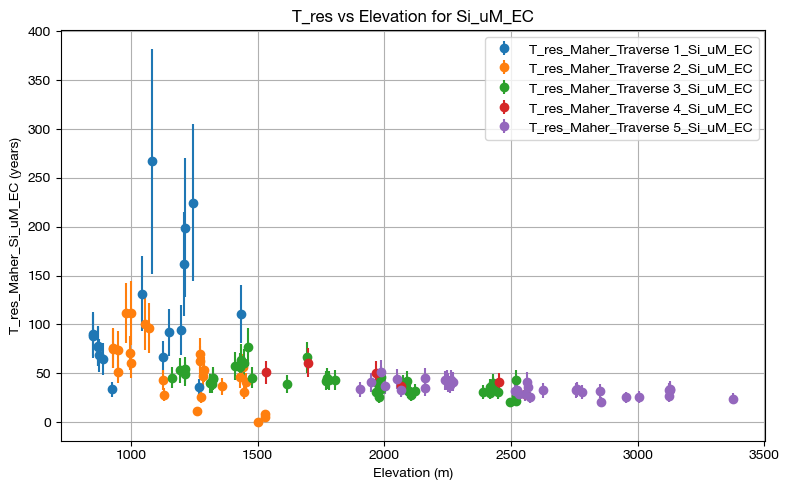

Optimized Monte Carlo simulation plot: Maher model residence time vs Elevation for Si_uM_EC with mean and std error bars.


In [29]:

# Convert T_res for Si_uM_EC to numeric
for traverse_name, traverse_sims in simulated_traverses.items():
    for df_traverse_sim in traverse_sims:
        df_traverse_sim["T_res_Maher_Si_uM_EC"] = pd.to_numeric(df_traverse_sim["T_res_Maher_Si_uM_EC"], errors='coerce')

# Define reasonable elevation limits (adjust if needed)
elevation_min, elevation_max = 0, 6000  # Set limits based on expected elevation range

# Create figure for Si_uM_EC only
fig, ax = plt.subplots(figsize=(8, 5))

# Plot individual samples with error bars
for traverse_name, traverse_sims in simulated_traverses.items():
    df_traverse_summary = pd.concat(traverse_sims).groupby("Index").agg({
        "Elevation": "mean",
        "T_res_Maher_Si_uM_EC": ["mean", "std"]
    }).reset_index()
    
    valid_data = df_traverse_summary[
        (df_traverse_summary[('T_res_Maher_Si_uM_EC', 'mean')] < 1000) &
        (df_traverse_summary[('Elevation', 'mean')] >= elevation_min) &
        (df_traverse_summary[('Elevation', 'mean')] <= elevation_max)
    ]
    
    if not valid_data.empty:
        ax.errorbar(
            valid_data[('Elevation', 'mean')], 
            valid_data[('T_res_Maher_Si_uM_EC', 'mean')],
            yerr=valid_data[('T_res_Maher_Si_uM_EC', 'std')],
            fmt='o', label=f"T_res_Maher_{traverse_name}_Si_uM_EC"
        )

ax.set_ylabel("T_res_Maher_Si_uM_EC (years)")
ax.set_title("T_res vs Elevation for Si_uM_EC")
ax.legend()
ax.grid(True)
ax.set_xlabel("Elevation (m)")

plt.tight_layout()
plt.show()
plt.close()

print("Optimized Monte Carlo simulation plot: Maher model residence time vs Elevation for Si_uM_EC with mean and std error bars.")


# Fontorbe


In [30]:
S = 0.1  # Specific surface area (m^2/g)

X_r = 0.2  # Mineral concentration in rock (unitless, g/g)

rho_plag = 2.7 * 1000 * 1000 #g/m^3

k = 10**(-15) # Reaction rate (mol/m^2/s)

phi = 0.1

R_n_Fontorbe = k * S * rho_plag * X_r  # Rate constant (mol/m^2/s)

f = 0.5

print(f"Rate constant R_n_Fontorbe: {R_n_Fontorbe:.2e} mol/m^2/s")


Rate constant R_n_Fontorbe: 5.40e-11 mol/m^2/s


### Calculating it in generaly

In [31]:
def calculate_T_res_Model4_Fontorbe(C, C_0, R_n_Fontorbe):


    T_res = (C - C_0) * phi / ((1-f) * R_n_Fontorbe )
    
    if isinstance(T_res, (list, tuple, np.ndarray)):
        T_res = T_res[0]  # Extract the first value if it's an array

    if not np.isscalar(T_res) or np.isnan(T_res):
        return np.nan  # Ensure we return a single number

    T_res_yr = T_res * 10**(-3) / 31557600 # Convert seconds to years
    
    
    return float(T_res_yr)  # Ensure it's a float


for i in range(1, 6):  # Loop through df_traverse1 to df_traverse5
    df_name = f"df_traverse{i}"
    df = globals()[df_name]  # Get the actual DataFrame object

    for element in elements_micro:
        col_name = f'T_res_Fontorbe_{element}'
        df[col_name] = df.apply(
            lambda row: calculate_T_res_Model4_Fontorbe(
                row[element], row[f'C_0_{element}'],
                R_n_Fontorbe
            ), axis=1
        )


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/345881395.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.apply(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/345881395.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.apply(
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/345881395.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [32]:


print("T_res_Fontorbe Range for Each Element in Each DataFrame:")

for i in range(1, 6):  # Loop through df_traverse1 to df_traverse5
    df_name = f"df_traverse{i}"
    df = globals()[df_name]  # Get the actual DataFrame object

    print(f"\n### {df_name} ###")

    for element in elements_micro:
        col_name = f'T_res_Fontorbe_{element}'

        # Drop NaNs and ensure the column is numeric
        T_res_series = pd.to_numeric(df[col_name], errors='coerce').dropna()

        # Remove values greater than 1000 years
        T_res_series = T_res_series[T_res_series < 1000]

        if not T_res_series.empty:
            T_res_min = T_res_series.min()
            T_res_max = T_res_series.max()
            print(f"Element: {element}, T_res range: {T_res_min:.2f} to {T_res_max:.2f} years")
        else:
            print(f"Element: {element}, No valid T_res values available")


T_res_Fontorbe Range for Each Element in Each DataFrame:

### df_traverse1 ###
Element: K_uM_EC, T_res range: 0.74 to 10.61 years
Element: Ca_uM_EC, T_res range: 2.51 to 112.55 years
Element: Si_uM_EC, T_res range: 12.05 to 90.85 years
Element: Na_uM_EC, T_res range: 17.20 to 56.17 years
Element: Sr_uM_EC, T_res range: 0.00 to 0.09 years
Element: Al_uM_EC, T_res range: 0.00 to 0.08 years
Element: Mg_uM_EC, T_res range: 0.56 to 18.93 years

### df_traverse2 ###
Element: K_uM_EC, T_res range: 0.67 to 21.75 years
Element: Ca_uM_EC, T_res range: -0.18 to 64.11 years
Element: Si_uM_EC, T_res range: -11.16 to 53.97 years
Element: Na_uM_EC, T_res range: -2.74 to 47.50 years
Element: Sr_uM_EC, T_res range: -0.00 to 0.13 years
Element: Al_uM_EC, T_res range: -0.00 to 0.34 years
Element: Mg_uM_EC, T_res range: -0.12 to 16.09 years

### df_traverse3 ###
Element: K_uM_EC, T_res range: 0.15 to 3.26 years
Element: Ca_uM_EC, T_res range: -0.05 to 13.55 years
Element: Si_uM_EC, T_res range: -0.83 to 4

/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/2123617359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse1[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse1[f"T_res_Fontorbe_{element}"], errors='coerce')
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/2123617359.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_traverse2[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse2[f"T_res_Fontorbe_{element}"], errors='coerce')
/var/folders/9m/bjwj

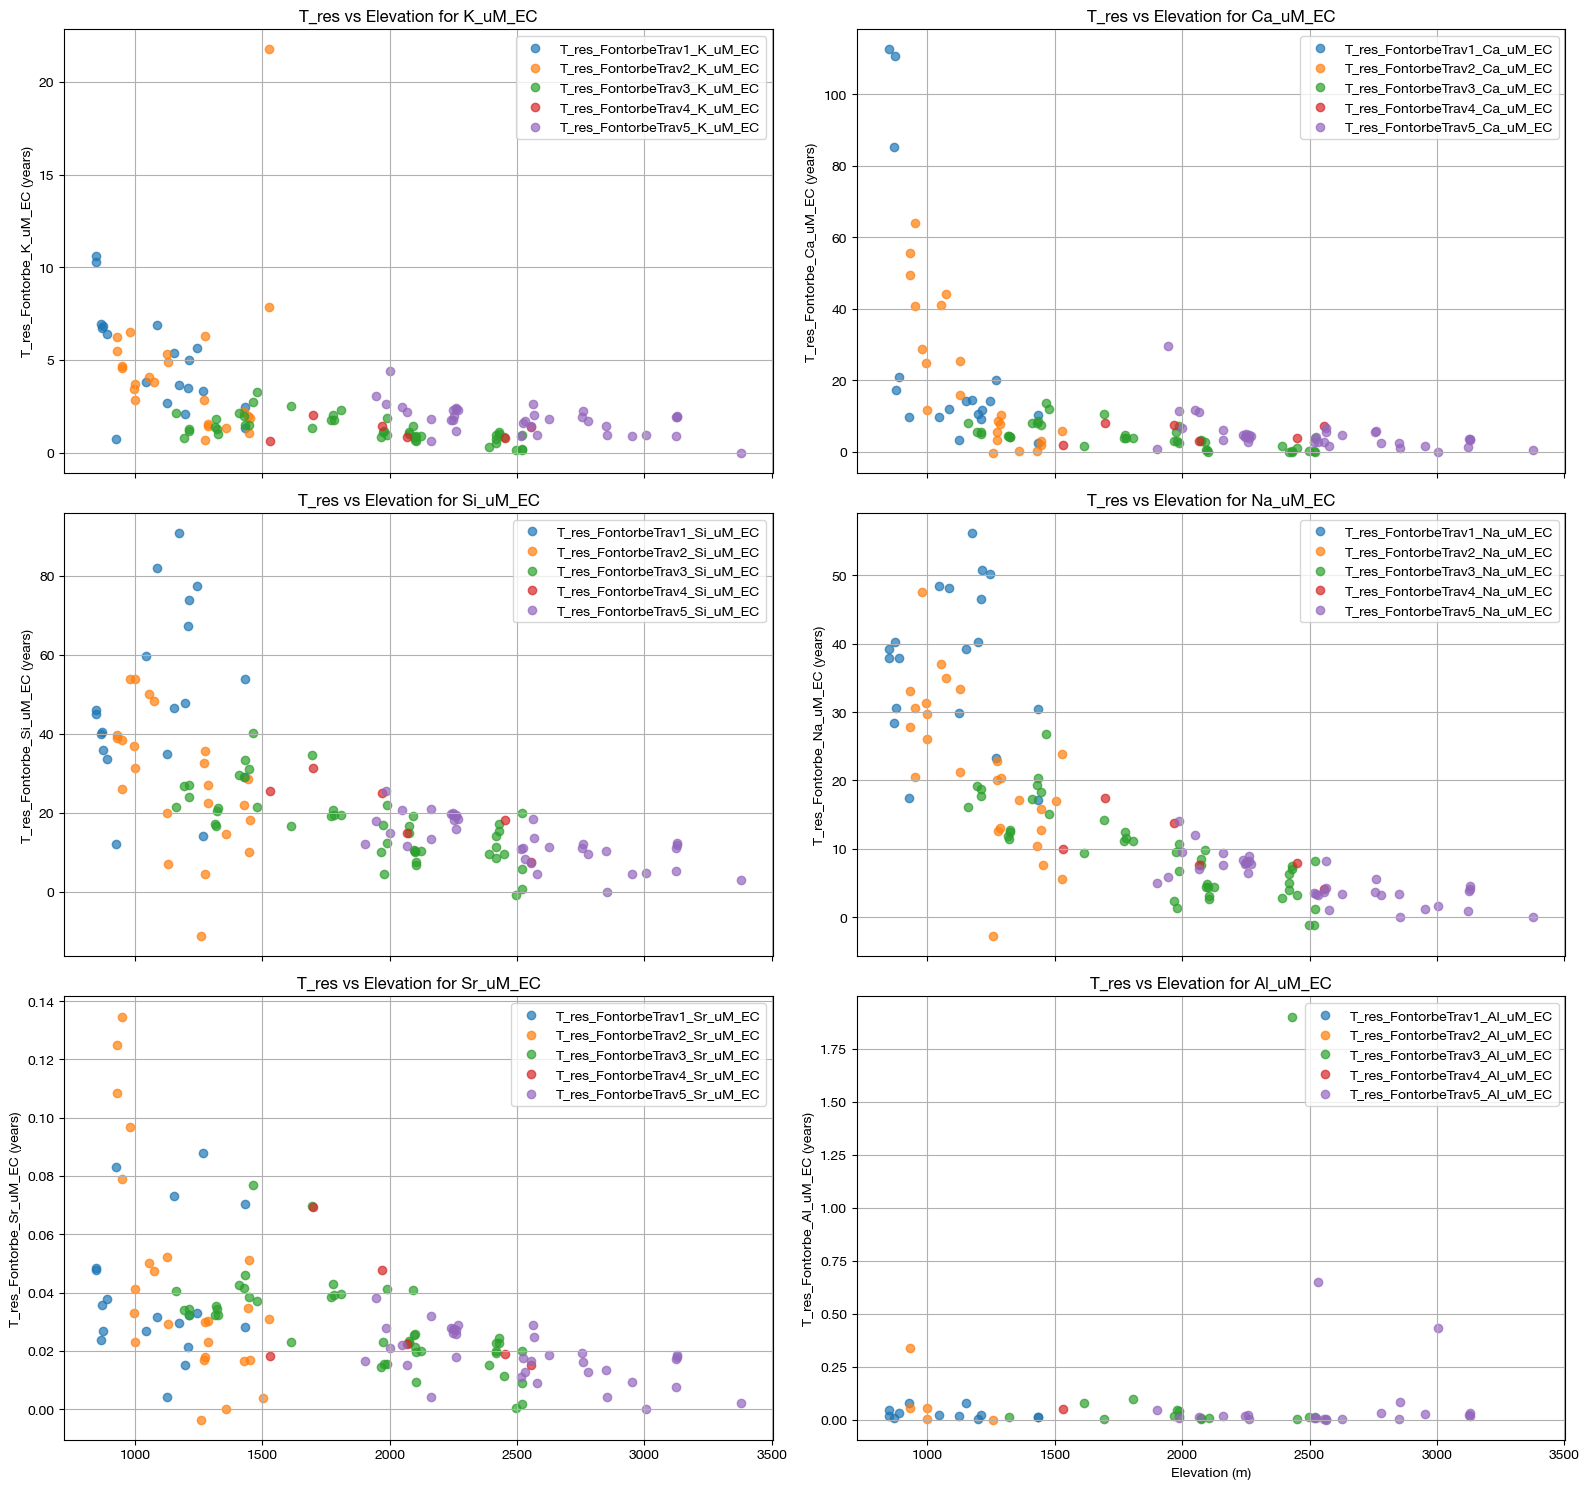

In [33]:
# Convert all T_res columns to numeric to avoid errors
for element in elements_micro:
    df_traverse1[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse1[f"T_res_Fontorbe_{element}"], errors='coerce')
    df_traverse2[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse2[f"T_res_Fontorbe_{element}"], errors='coerce')
    df_traverse3[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse3[f"T_res_Fontorbe_{element}"], errors='coerce')
    df_traverse4[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse4[f"T_res_Fontorbe_{element}"], errors='coerce')
    df_traverse5[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse5[f"T_res_Fontorbe_{element}"], errors='coerce')



import matplotlib.pyplot as plt

# Determine the number of elements
num_elements = len(elements_micro)

# Create a figure with subplots (adjusting rows/columns dynamically)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over each element and plot in a separate subplot
for ax, element in zip(axes, elements_micro):
    for i in range(1, 6):  # Loop through df_traverse1 to df_traverse5
        df_name = f"df_traverse{i}"
        df = globals()[df_name]  # Get the actual DataFrame object

        # Filter out values greater than 1000 years
        valid_data = df[df[f"T_res_Fontorbe_{element}"] < 1000]

        # Plot scatter if data exists
        if not valid_data.empty:
            ax.scatter(
                valid_data["Elevation"], valid_data[f"T_res_Fontorbe_{element}"],
                alpha=0.7, label=f"T_res_FontorbeTrav{i}_{element}"
            )

    ax.set_ylabel(f"T_res_Fontorbe_{element} (years)")
    ax.set_title(f"T_res vs Elevation for {element}")
    ax.legend()
    ax.grid(True)

# Remove any unused subplots
for i in range(num_elements, len(axes)):
    fig.delaxes(axes[i])

# Set common x-axis label
axes[-1].set_xlabel("Elevation (m)")

# Adjust layout
plt.tight_layout()
plt.show()

plt.close()


### Monte Carlo

In [34]:
# Run Monte Carlo simulations for Fontorbe model
for i in range(N_simulations):
    df_sim = df_monte_carlo.loc[i].copy()  # Get a copy of the simulation row
    
    # Apply uncertainty to Fontorbe model parameters
    S_sim = S * np.random.normal(1, uncertainty_levels['S'])
    rho_plag_sim = rho_plag * np.random.normal(1, uncertainty_levels['rho_plag'])
    phi_sim = phi * np.random.normal(1, uncertainty_levels['phi'])
    R_n_Fontorbe_sim = k_sim * S_sim * rho_plag_sim * X_r_sim  # Simulated rate constant for Fontorbe

    # Compute residence time for each traverse separately
    for traverse_name in ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 4', 'Traverse 5']:
        df_traverse_sim = df_sim[df_sim['Traverse'] == traverse_name].copy()

        if df_traverse_sim.empty:
            continue  # Skip empty traverses

        for element in elements_micro:
            if element in df_traverse_sim.columns:
                df_traverse_sim[f'T_res_Fontorbe_{element}'] = df_traverse_sim.apply(
                    lambda row: calculate_T_res_Model4_Fontorbe(
                        row[element], row[f'C_0_{element}'], R_n_Fontorbe_sim
                    ), axis=1
                )

                # ✅ Store computed values directly into `df_sim`
                df_sim.loc[df_traverse_sim.index, f'T_res_Fontorbe_{element}'] = df_traverse_sim[f'T_res_Fontorbe_{element}']

        simulated_traverses.setdefault(traverse_name, []).append(df_traverse_sim)

    # ✅ Store df_sim *correctly* to monte_carlo_results
    monte_carlo_results[i] = df_sim.copy()

# ✅ Now `df_monte_carlo` should contain T_res_Fontorbe
df_monte_carlo = pd.concat(monte_carlo_results, keys=range(N_simulations), names=["Simulation", "Index"])

# 🔍 Debugging: Check if T_res_Fontorbe exists in df_monte_carlo
print("\n🔎 Checking `df_monte_carlo` for T_res_Fontorbe columns:")
print(df_monte_carlo.filter(like="T_res_Fontorbe").head())  # ✅ Should now contain values



🔎 Checking `df_monte_carlo` for T_res_Fontorbe columns:
                  T_res_Fontorbe_K_uM_EC  T_res_Fontorbe_Ca_uM_EC  \
Simulation Index                                                    
0          33                   7.190815                41.208057   
           34                        NaN                      NaN   
           35                   6.618072                 7.869302   
           36                   3.642131                 6.400304   
           37                   3.447666                 4.962459   

                  T_res_Fontorbe_Si_uM_EC  T_res_Fontorbe_Na_uM_EC  \
Simulation Index                                                     
0          33                   62.312289                28.969885   
           34                         NaN                      NaN   
           35                   36.930145                11.923070   
           36                   41.147733                11.667962   
           37                   56.2983

In [35]:
# Combine all simulations into a single DataFrame
df_monte_carlo = pd.concat(monte_carlo_results, keys=range(N_simulations), names=["Simulation", "Index"])

# 🔎 Debugging: Check if T_res_Fontorbe exists in df_monte_carlo
print("\n🔎 Checking `df_monte_carlo` for T_res_Fontorbe columns:")
print(df_monte_carlo.filter(like="T_res_Fontorbe").head())  # ✅ Should now contain values

# Select only numeric columns for aggregation
numeric_cols = df_monte_carlo.select_dtypes(include=[np.number]).columns
if numeric_cols.any():
    df_monte_carlo_summary = df_monte_carlo[numeric_cols].groupby("Index").agg(["mean", "std"])

# 🔎 Debugging: Check Monte Carlo summary for Fontorbe Model
print("\n🔎 Checking Monte Carlo Summary for Fontorbe Model:")
print(df_monte_carlo_summary.filter(like="T_res_Fontorbe").head())  # ✅ Should now contain mean/std



🔎 Checking `df_monte_carlo` for T_res_Fontorbe columns:
                  T_res_Fontorbe_K_uM_EC  T_res_Fontorbe_Ca_uM_EC  \
Simulation Index                                                    
0          33                   7.190815                41.208057   
           34                        NaN                      NaN   
           35                   6.618072                 7.869302   
           36                   3.642131                 6.400304   
           37                   3.447666                 4.962459   

                  T_res_Fontorbe_Si_uM_EC  T_res_Fontorbe_Na_uM_EC  \
Simulation Index                                                     
0          33                   62.312289                28.969885   
           34                         NaN                      NaN   
           35                   36.930145                11.923070   
           36                   41.147733                11.667962   
           37                   56.2983

In [36]:
print("🔎 Checking Monte Carlo Summary for Residence Times:")
print(df_monte_carlo_summary.filter(like="T_res_").head())


🔎 Checking Monte Carlo Summary for Residence Times:
      T_res_Maher_K_uM_EC           T_res_Maher_Ca_uM_EC             \
                     mean       std                 mean        std   
Index                                                                 
33               7.349834  1.725656            64.623958  17.168020   
34                    NaN       NaN                  NaN        NaN   
35               5.363681  1.240428             6.813831   1.510301   
36               3.430552  0.762422             4.771034   1.084119   
37               2.490243  0.545642             3.681464   0.821225   

      T_res_Maher_Si_uM_EC            T_res_Maher_Na_uM_EC             \
                      mean        std                 mean        std   
Index                                                                   
33               75.263510  19.538050            46.989493  13.198205   
34                     NaN        NaN                  NaN        NaN   
35            

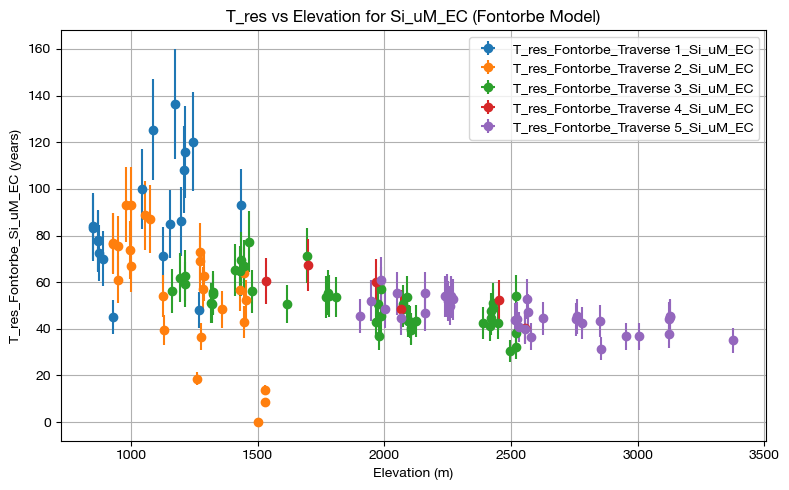

✅ Optimized Monte Carlo simulation plot: Fontorbe model residence time vs Elevation for Si_uM_EC with mean and std error bars.


In [37]:
# Convert T_res for Si_uM_EC in Fontorbe model to numeric in df_monte_carlo
df_monte_carlo["T_res_Fontorbe_Si_uM_EC"] = pd.to_numeric(df_monte_carlo["T_res_Fontorbe_Si_uM_EC"], errors='coerce')

# Define reasonable elevation limits (adjust if needed)
elevation_min, elevation_max = 0, 6000  # Set limits based on expected elevation range

# Create figure for Si_uM_EC only (Fontorbe)
fig, ax = plt.subplots(figsize=(8, 5))

# Group by traverse and calculate mean/std for T_res vs Elevation
df_summary = df_monte_carlo.groupby(["Traverse", "Index"]).agg({
    "Elevation": ["mean","std"],
    "T_res_Fontorbe_Si_uM_EC": ["mean", "std"]
}).reset_index()

# Iterate through traverses and plot
for traverse_name, df_traverse_summary in df_summary.groupby("Traverse"):
    valid_data = df_traverse_summary[
        (df_traverse_summary[("T_res_Fontorbe_Si_uM_EC", "mean")] < 1000) &
        (df_traverse_summary[("Elevation", "mean")] >= elevation_min) &
        (df_traverse_summary[("Elevation", "mean")] <= elevation_max)
    ]
    
    if not valid_data.empty:
        ax.errorbar(
            valid_data[("Elevation", "mean")], 
            valid_data[("T_res_Fontorbe_Si_uM_EC", "mean")],
            yerr=valid_data[("T_res_Fontorbe_Si_uM_EC", "std")],
            xerr = valid_data[("Elevation", "std")],
            fmt='o', label=f"T_res_Fontorbe_{traverse_name}_Si_uM_EC"
        )

# Formatting the plot
ax.set_ylabel("T_res_Fontorbe_Si_uM_EC (years)")
ax.set_title("T_res vs Elevation for Si_uM_EC (Fontorbe Model)")
ax.legend()
ax.grid(True)
ax.set_xlabel("Elevation (m)")

plt.tight_layout()
plt.show()
plt.close()

print("✅ Optimized Monte Carlo simulation plot: Fontorbe model residence time vs Elevation for Si_uM_EC with mean and std error bars.")


# Calculating Delta G


In [38]:
# Delta G_R at standard temp and pressure

T = 273 + 25

R = 8.314

ln_k = 5.58

delta_G_R_0 = -R * T * ln_k

print(f"Delta G_R at standard temp and pressure: {delta_G_R_0:.2f} J/mol")

Delta G_R at standard temp and pressure: -13824.85 J/mol


### Calculating it Generally

In [39]:
for i in range(1, 6):  # Loop through df_traverse1 to df_traverse5
    df_name = f"df_traverse{i}"
    df = globals()[df_name]  # Get the actual DataFrame object

    # Convert concentrations to mol/L
    df['Si_mol_L'] = df['Si_uM_EC'] * 10**(-6)
    df['Na_mol_L'] = df['Na_uM_EC'] * 10**(-6)
    df['Ca_mol_L'] = df['Ca_uM_EC'] * 10**(-6)

    # Calculate Q for each sample
    df['Q'] = df['Si_mol_L']**1.6 * df['Na_mol_L']**0.8 * df['Ca_mol_L']**0.2

    # Calculate delta G_R and convert to kJ/mol
    df['delta_G_R'] = delta_G_R_0 + R * T * np.log(df['Q'])
    df['delta_G_R_kJmol'] = df['delta_G_R'] / 1000


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/645237304.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Si_mol_L'] = df['Si_uM_EC'] * 10**(-6)
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/645237304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Na_mol_L'] = df['Na_uM_EC'] * 10**(-6)
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_62891/645237304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

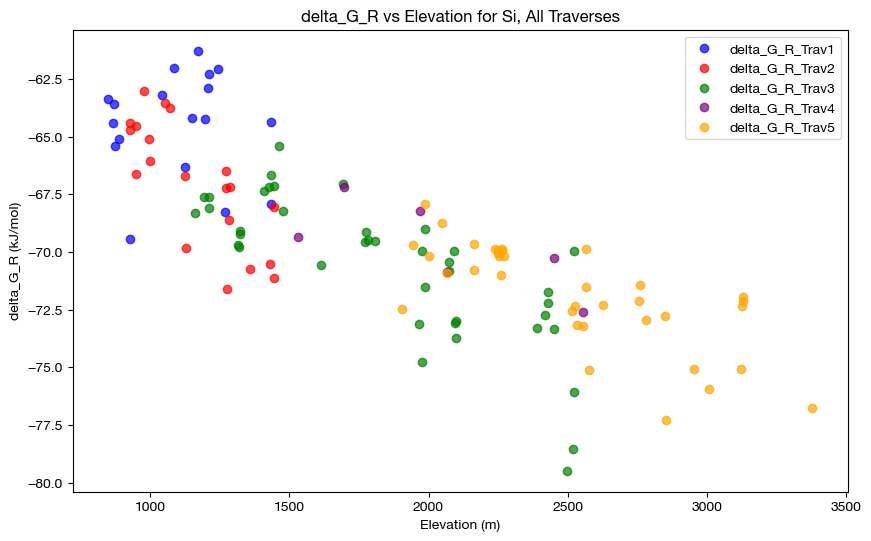

In [40]:
# # plot delta_G_R vs Elevation for Si

# plt.figure(figsize=(10, 6))

# # Plot the data

# plt.scatter(df_traverse3['Elevation'], df_traverse3['delta_G_R_kJmol'], label='delta_G_R_Trav3', color = 'blue')
# plt.scatter(df_traverse1['Elevation'], df_traverse1['delta_G_R_kJmol'], label='delta_G_R_Trav1', color = 'red')


# # Add labels and title
# plt.xlabel('Elevation (m)')
# plt.ylabel('delta_G_R (kJ/mol)')

# plt.title('delta_G_R vs Elevation for Si, Traverse 3+1')

# # Add a legend

# plt.legend()
# #plt.yscale('log')

# # Display the plot
# plt.savefig('delta_G_R_Si_comparison_Trav1.pdf')


# plt.show()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Define colors for different traverses
colors = ['blue', 'red', 'green', 'purple', 'orange']  # Add more if needed

# Plot the data for each df_traverse
for i, color in zip(range(1, 6), colors):
    df_name = f"df_traverse{i}"
    df = globals()[df_name]  # Get the actual DataFrame object

    plt.scatter(df['Elevation'], df['delta_G_R_kJmol'], 
                label=f'delta_G_R_Trav{i}', color=color, alpha=0.7)

# Add labels and title
plt.xlabel('Elevation (m)')
plt.ylabel('delta_G_R (kJ/mol)')
plt.title('delta_G_R vs Elevation for Si, All Traverses')

# Add a legend
plt.legend()

# Save and display the plot
plt.savefig('delta_G_R_Si_comparison_AllTraverses.pdf')
plt.show()


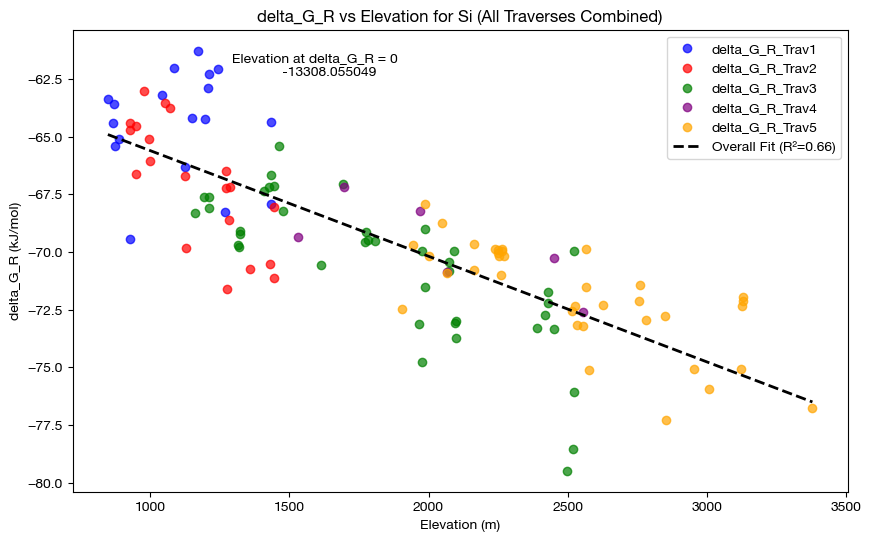

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(10, 6))

colors = ['blue', 'red', 'green', 'purple', 'orange']  # Adjust as needed

# Combine all traverse data into one DataFrame
all_data = []

for i in range(1, 6):
    df_name = f"df_traverse{i}"
    
    if df_name not in globals():  # Check if the DataFrame exists
        print(f"Warning: {df_name} not found. Skipping.")
        continue
    
    df = globals()[df_name]  # Get DataFrame

    # Drop NaN or inf values
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Elevation', 'delta_G_R_kJmol'])
    
    if df.empty:  # Skip if DataFrame is empty
        print(f"Warning: {df_name} is empty after filtering. Skipping.")
        continue

    all_data.append(df[['Elevation', 'delta_G_R_kJmol']])

# Merge all traverses into one DataFrame
if not all_data:
    raise ValueError("No valid data available for regression.")

df_combined = pd.concat(all_data, ignore_index=True)

# Extract independent (Elevation) and dependent (delta_G_R) variables
X = df_combined[['Elevation']].values  # Ensure X is 2D
y = df_combined['delta_G_R_kJmol'].values

# Perform linear regression on the combined dataset
model = LinearRegression()
model.fit(X, y)

# Calculate overall R²
r_squared = model.score(X, y)

# Compute the extrapolated elevation where delta_G_R = 0
if model.coef_[0] != 0:  # Avoid division by zero
    elevation_at_zero_dG = -model.intercept_ / model.coef_[0]
else:
    elevation_at_zero_dG = np.nan  # Undefined if the slope is zero

# Generate line for visualization
x_range = np.linspace(min(X), max(X), 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# Plot original data for all traverses
for i, color in zip(range(1, 6), colors):
    df_name = f"df_traverse{i}"
    if df_name in globals():
        df = globals()[df_name].replace([np.inf, -np.inf], np.nan).dropna(subset=['Elevation', 'delta_G_R_kJmol'])
        if not df.empty:
            plt.scatter(df['Elevation'], df['delta_G_R_kJmol'], 
                        label=f'delta_G_R_Trav{i}', 
                        color=color, alpha=0.7)

# Plot unified regression line
plt.plot(x_range, y_pred, color='black', linestyle='dashed', linewidth=2, label=f'Overall Fit (R²={r_squared:.2f})')


extrapolated_df = pd.DataFrame({'Elevation at delta_G_R = 0': [elevation_at_zero_dG]})
# plot extrapolated_df on the plot

plt.text(0.2, 0.95, extrapolated_df.to_string(index=False),
            horizontalalignment='left',
            verticalalignment='top',
            transform=plt.gca().transAxes)


# Labels and title
plt.xlabel('Elevation (m)')
plt.ylabel('delta_G_R (kJ/mol)')
plt.title('delta_G_R vs Elevation for Si (All Traverses Combined)')

# Add legend
plt.legend()

# Save and show the plot
plt.savefig('delta_G_R_Si_combined_fit.pdf')
plt.show()



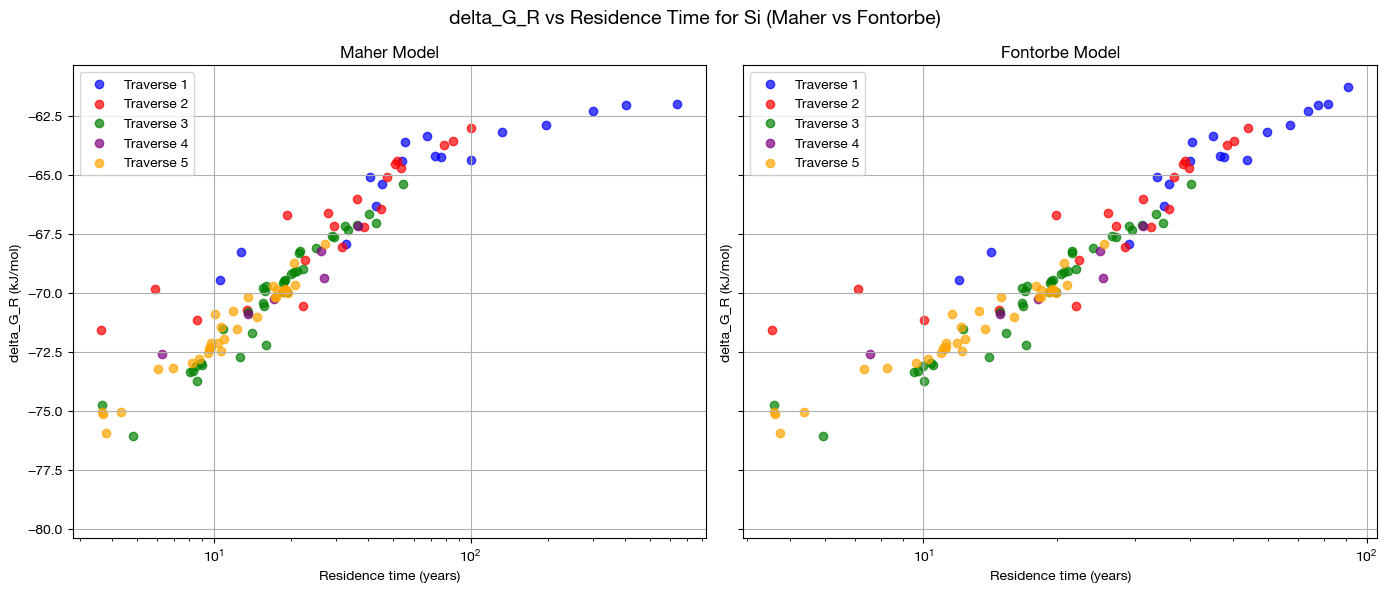

In [42]:
# # plot delta_G_R vs Elevation for Si

# plt.figure(figsize=(10, 6))

# # Plot the data

# plt.scatter(df_traverse3['T_res_Maher_Si_uM_EC'], df_traverse3['delta_G_R_kJmol'], color = 'blue', label = 'T_res_Maher')
# plt.scatter(df_traverse3['T_res_Fontorbe_Si_uM_EC'], df_traverse3['delta_G_R_kJmol'], color = 'red', label = 'T_res_Fontorbe')

# plt.scatter(df_traverse1['T_res_Maher_Si_uM_EC'], df_traverse1['delta_G_R_kJmol'], color = 'blue', marker = 'x', label = 'T_res_Maher')
# plt.scatter(df_traverse1['T_res_Fontorbe_Si_uM_EC'], df_traverse1['delta_G_R_kJmol'], color = 'red', marker = 'x', label = 'T_res_Fontorbe')



# # Add labels and title
# plt.xlabel('Residence time (years)')
# plt.ylabel('delta_G_R (kJ/mol)')

# plt.title('delta_G_R vs Residence Time for Si, Traverse 3')

# # Add a legend

# plt.legend()
# #plt.yscale('log')


# # Display the plot
# plt.savefig('delta_G_R_Si_time_trav1.pdf')


# plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Define colors for different traverses
traverse_colors = {1: 'blue', 2: 'red', 3: 'green', 4: 'purple', 5: 'orange'}
markers = {1: 'o', 2: 'o', 3: 'o', 4: 'o', 5: 'o'}  # Different markers for each traverse

# Create figure and two subplots (one for Maher, one for Fontorbe)
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

# Titles for the subplots
axes[0].set_title("Maher Model")
axes[1].set_title("Fontorbe Model")

# Loop through df_traverse1 to df_traverse5
for i in range(1, 6):  
    df_name = f"df_traverse{i}"
    df = globals()[df_name]  # Get the actual DataFrame object

    color = traverse_colors[i]  # Assign color based on traverse
    marker = markers[i]  # Assign marker based on traverse

    # Plot Maher model residence time
    axes[0].scatter(df['T_res_Maher_Si_uM_EC'], df['delta_G_R_kJmol'], 
                    color=color, marker=marker, 
                    label=f'Traverse {i}', alpha=0.7)

    # Plot Fontorbe model residence time
    axes[1].scatter(df['T_res_Fontorbe_Si_uM_EC'], df['delta_G_R_kJmol'], 
                    color=color, marker=marker, 
                    label=f'Traverse {i}', alpha=0.7)

# Set common x/y labels
for ax in axes:
    ax.set_xlabel('Residence time (years)')
    ax.set_xscale('log')
    ax.set_ylabel('delta_G_R (kJ/mol)')
    ax.legend()
    ax.grid(True)

# Set overall figure title
fig.suptitle('delta_G_R vs Residence Time for Si (Maher vs Fontorbe)', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.savefig('delta_G_R_Si_time_Maher_vs_Fontorbe.pdf')
plt.show()


### Monte Carlo

In [43]:
# Define Delta G_R calculation parameters with uncertainties
T_mean = 273 + 25  # Temperature in Kelvin
R_mean = 8.314  # Universal gas constant (J/mol/K)
ln_k_mean = 5.58  # Log of equilibrium constant

# Retrieve uncertainties from the defined dictionary
T_uncertainty = uncertainty_levels['T']
R_uncertainty = uncertainty_levels['R']
ln_k_uncertainty = uncertainty_levels['ln_k']

In [44]:
# Prepare storage for simulation results
monte_carlo_results = {}


# Convert df_monte_carlo_summary into dictionaries for fast lookup
mean_dict = df_monte_carlo_summary.xs("mean", axis=1, level=1).to_dict(orient="index")
std_dict = df_monte_carlo_summary.xs("std", axis=1, level=1).to_dict(orient="index")

# Run Monte Carlo simulations
for i in range(N_simulations):
    df_sim = df_monte_carlo.loc[i].copy()  # Get a copy of the simulation row

    # Sample global parameters with uncertainties
    T_sim = T_mean * np.random.normal(1, T_uncertainty)
    R_sim = R_mean * np.random.normal(1, R_uncertainty)
    ln_k_sim = ln_k_mean * np.random.normal(1, ln_k_uncertainty)

    # Compute ΔG_R0 for this simulation
    delta_G_R0_sim = -R_sim * T_sim * ln_k_sim

    # Compute ΔG_R for each traverse separately
    for traverse_name in ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 4', 'Traverse 5']:
        df_traverse_sim = df_sim[df_sim['Traverse'] == traverse_name].copy()

        if df_traverse_sim.empty:
            continue  # Skip empty traverses

        for index in df_traverse_sim.index:
            # Sample concentrations with uncertainty
            Si_sim = np.random.normal(mean_dict[index]['Si_uM_EC'], std_dict[index]['Si_uM_EC']) * 1e-6
            Na_sim = np.random.normal(mean_dict[index]['Na_uM_EC'], std_dict[index]['Na_uM_EC']) * 1e-6
            Ca_sim = np.random.normal(mean_dict[index]['Ca_uM_EC'], std_dict[index]['Ca_uM_EC']) * 1e-6

            # Compute reaction quotient (Q)
            Q_sim = Si_sim**1.6 * Na_sim**0.8 * Ca_sim**0.2

            # Compute ΔG_R for this sample
            delta_G_R_sim = delta_G_R0_sim + R_sim * T_sim * np.log(Q_sim)
            delta_G_R_kJmol_sim = delta_G_R_sim / 1000  # Convert to kJ/mol

            # ✅ Store computed values directly into df_sim
            df_sim.loc[index, 'Q'] = Q_sim
            df_sim.loc[index, 'delta_G_R'] = delta_G_R_sim
            df_sim.loc[index, 'delta_G_R_kJmol'] = delta_G_R_kJmol_sim

        simulated_traverses.setdefault(traverse_name, []).append(df_traverse_sim)

    # ✅ Store df_sim *correctly* in monte_carlo_results
    monte_carlo_results[i] = df_sim.copy()

# ✅ Combine results into a single DataFrame
df_monte_carlo = pd.concat(monte_carlo_results, keys=range(N_simulations), names=["Simulation", "Index"])


In [45]:

# Select only numeric columns for aggregation
numeric_cols = df_monte_carlo.select_dtypes(include=[np.number]).columns
if numeric_cols.any():
    df_monte_carlo_summary = df_monte_carlo[numeric_cols].groupby("Index").agg(["mean", "std"])

# 🔎 Debugging: Check Monte Carlo summary for Fontorbe Model
print("\n🔎 Checking Monte Carlo Summary for Delta G:")
print(df_monte_carlo_summary.filter(like="delta_G_R").head())  # ✅ Should now contain mean/std
                                    


🔎 Checking Monte Carlo Summary for Delta G:
                    delta_G_R                   delta_G_R_kJmol          
                         mean          std                 mean       std
Index                                                                    
33    -64333.055669+0.000000j  6535.478811 -64.333056+0.000000j  6.535479
34    N0000000000a0000000000N          NaN  N00000000a00000000N       NaN
35    -70102.935108+0.000000j  7065.409036 -70.102935+0.000000j  7.065409
36    -69800.216388+0.000000j  7039.194840 -69.800216+0.000000j  7.039195
37    -67889.342339+0.000000j  6843.026519 -67.889342+0.000000j  6.843027


/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)


/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: Co

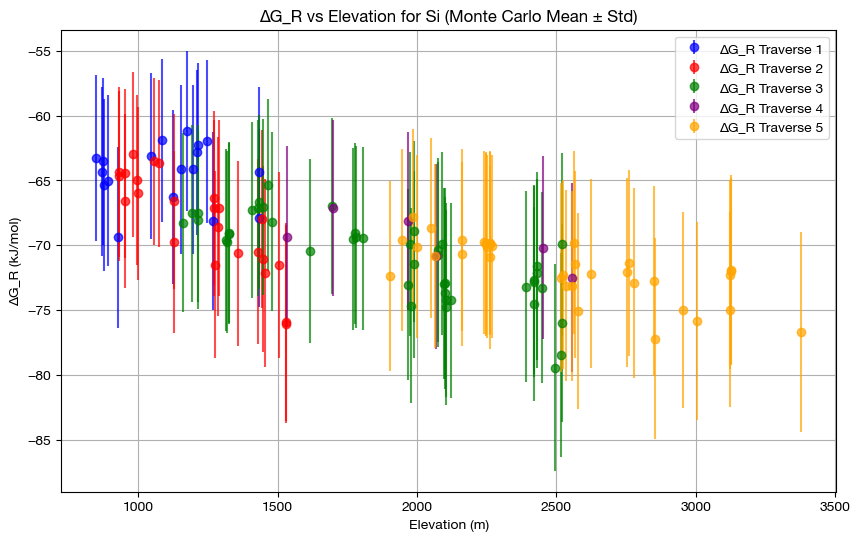

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define plot size
plt.figure(figsize=(10, 6))

# Define colors for different traverses
colors = ['blue', 'red', 'green', 'purple', 'orange']

# Loop through each traverse and aggregate results from df_monte_carlo
for i, color in zip(range(1, 6), colors):
    traverse_name = f"Traverse {i}"

    # Filter df_monte_carlo for the current traverse
    df_traverse_summary = df_monte_carlo[df_monte_carlo["Traverse"] == traverse_name].groupby("Index").agg({
        "Elevation": "mean",
        "delta_G_R_kJmol": ["mean", "std"]
    }).reset_index()


    # Ensure real values only
    df_traverse_summary[("delta_G_R_kJmol", "mean")] = df_traverse_summary[("delta_G_R_kJmol", "mean")].apply(lambda x: np.real(x))
    df_traverse_summary[("delta_G_R_kJmol", "std")] = df_traverse_summary[("delta_G_R_kJmol", "std")].apply(lambda x: np.real(x))
    
    # filter out delta_G_R values less than -140 kJ/mol (outlier)
    df_traverse_summary = df_traverse_summary[df_traverse_summary[("delta_G_R_kJmol", "mean")] > -140]

    # Ensure valid data before plotting
    if not df_traverse_summary.empty:
        plt.errorbar(
            df_traverse_summary[("Elevation", "mean")],
            df_traverse_summary[("delta_G_R_kJmol", "mean")],
            yerr=df_traverse_summary[("delta_G_R_kJmol", "std")],
            fmt='o', label=f'ΔG_R {traverse_name}', color=color, alpha=0.7
        )
    else:
        print(f"⚠️ Warning: No valid data for {traverse_name}")

# Add labels and title
plt.xlabel('Elevation (m)')
plt.ylabel('ΔG_R (kJ/mol)')
plt.title('ΔG_R vs Elevation for Si (Monte Carlo Mean ± Std)')

# Add a legend
plt.legend()
plt.grid(True)

# Save and show the plot
plt.savefig('delta_G_R_Si_comparison_MonteCarlo.pdf')
plt.show()


/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: Co

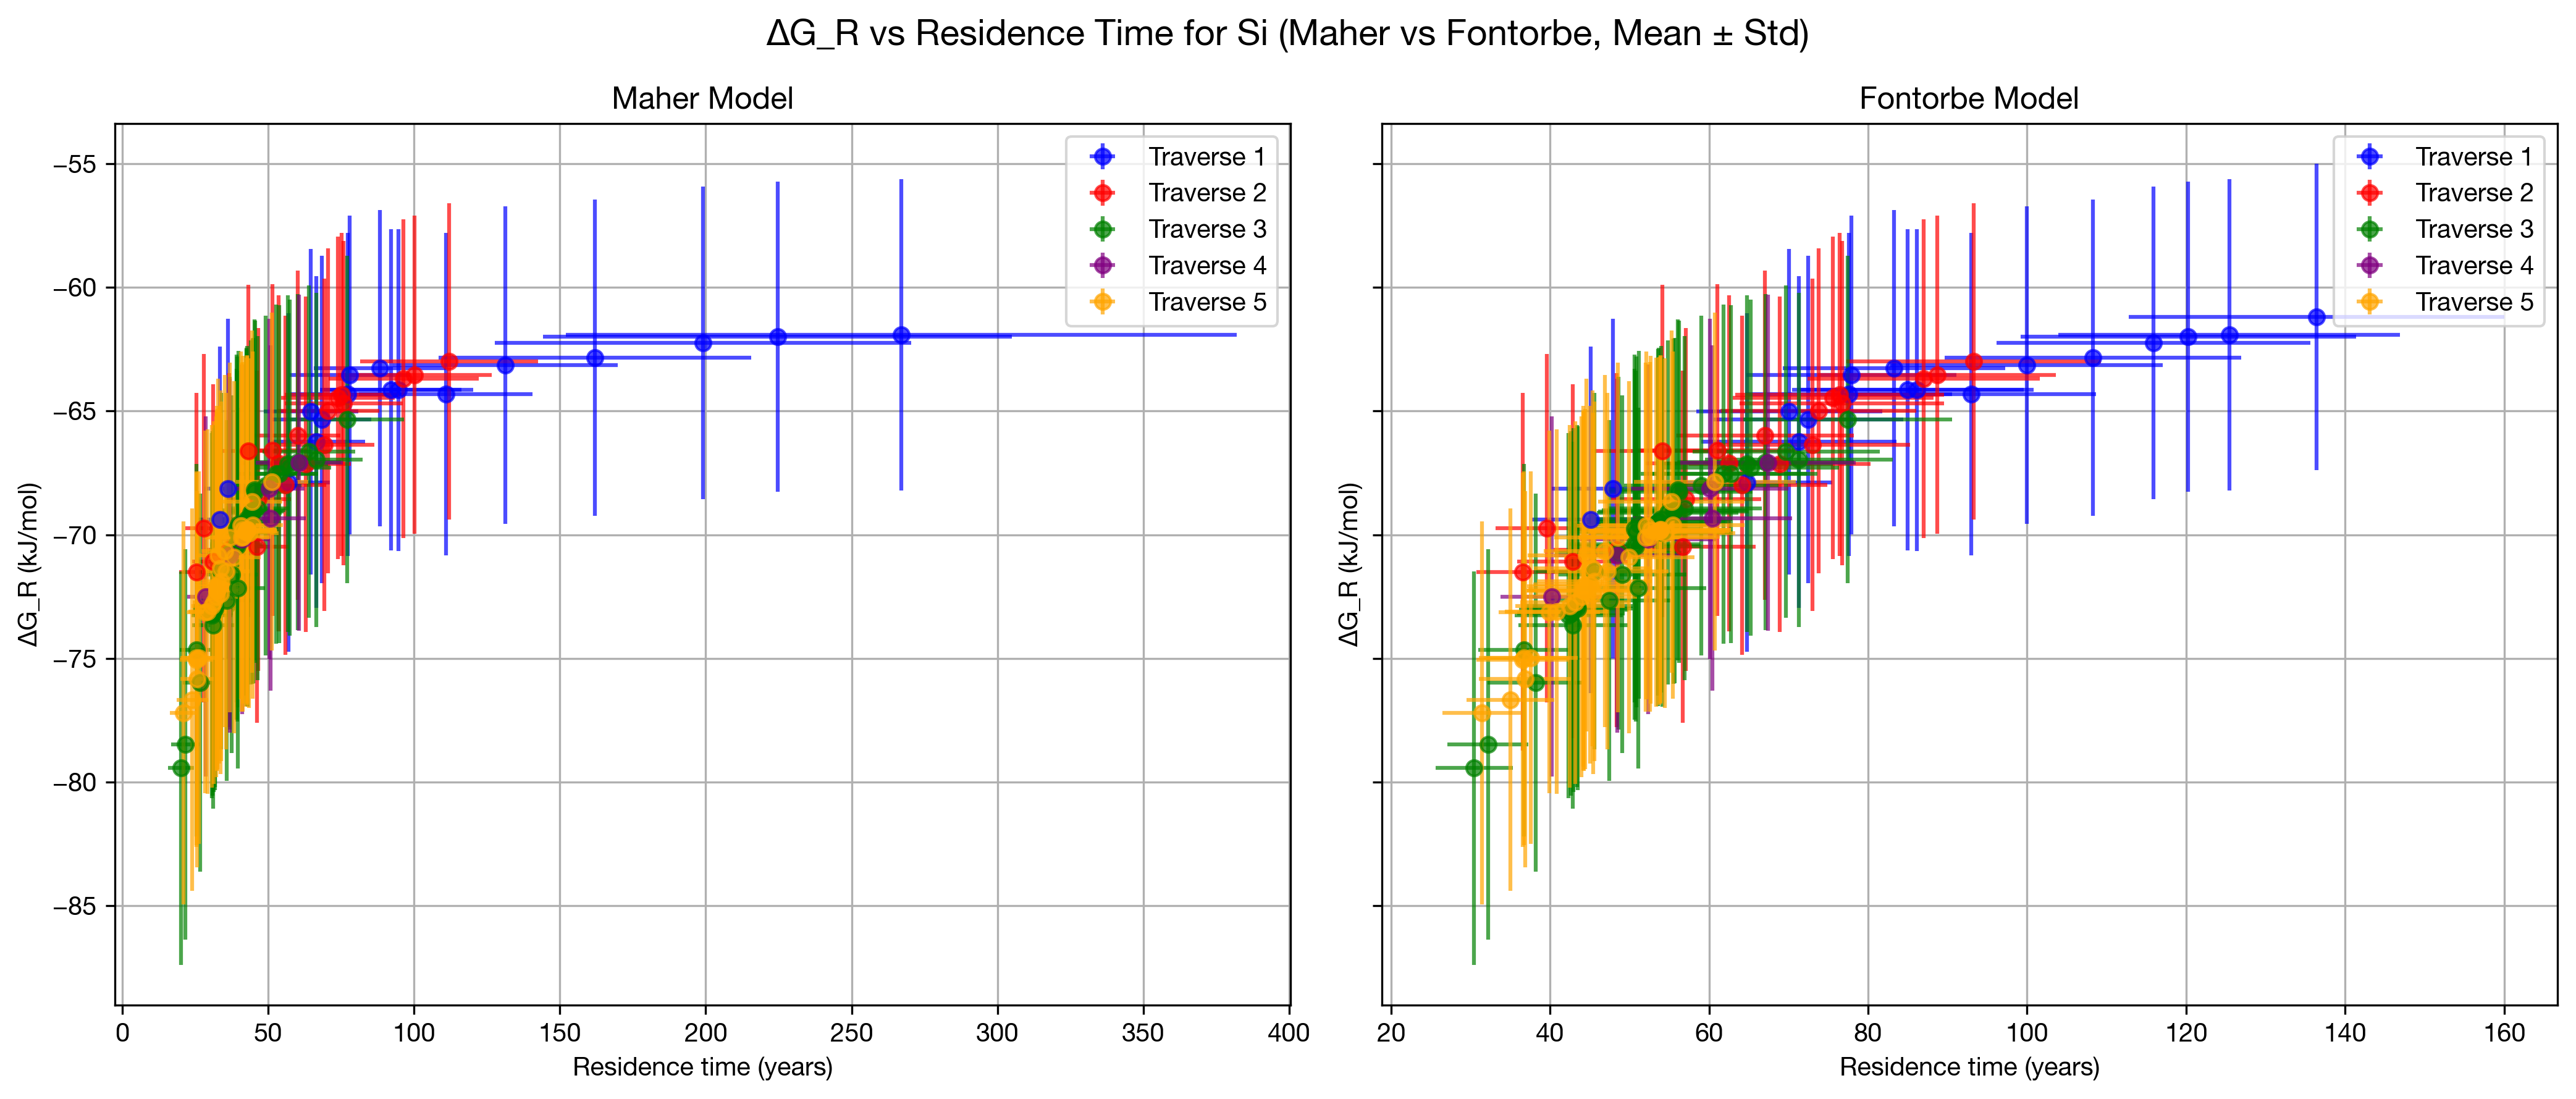

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors and markers for different traverses
traverse_colors = {1: 'blue', 2: 'red', 3: 'green', 4: 'purple', 5: 'orange'}
markers = {1: 'o', 2: 'o', 3: 'o', 4: 'o', 5: 'o'}  # Different markers for each traverse

# Create figure and two subplots (one for Maher, one for Fontorbe)
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True, dpi =  300)

# Titles for the subplots
axes[0].set_title("Maher Model")
axes[1].set_title("Fontorbe Model")

# Loop through each traverse and extract mean/std from df_monte_carlo
for i in range(1, 6):  
    traverse_name = f"Traverse {i}"

    df_traverse_summary = (
        df_monte_carlo[df_monte_carlo["Traverse"] == traverse_name]
        .groupby(["Index", "Sample ID"])  # Keep Sample ID in the index
        .agg({
            "T_res_Maher_Si_uM_EC": ["mean", "std"],
            "T_res_Fontorbe_Si_uM_EC": ["mean", "std"],
            "delta_G_R_kJmol": ["mean", "std"]
        })
        .reset_index()
    )

    # 🔥 Fix: Flatten MultiIndex columns
    df_traverse_summary.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_traverse_summary.columns]
    
    # List of Sample IDs to remove
    outliers = ["NEP22-61", "NEP22-62", "NEP24-061", "NEP24-064"]

    # Remove rows where "Sample ID_" matches any in the outliers list
    df_traverse_summary = df_traverse_summary[~df_traverse_summary["Sample ID_"].isin(outliers)]

    # Remove rows where delta_G_R_kJmol_mean has an imaginary part
    df_traverse_summary = df_traverse_summary[df_traverse_summary["delta_G_R_kJmol_mean"].apply(lambda x: np.isreal(x))]

    # Ensure only real values remain
    df_traverse_summary["delta_G_R_kJmol_mean"] = df_traverse_summary["delta_G_R_kJmol_mean"].apply(np.real)

    
    # filter out the following outliers with Sample ID_:
    #NEP22_62, NEP24_064, NEP24_061, NEP22_63
    #df_traverse_summary = df_traverse_summary[~df_traverse_summary["Sample ID_"].isin(["NEP22_62", "NEP24_064", "NEP24_061", "NEP22_63"])]

    # # Iterate over rows and print Sample ID_, delta G, and Residence Time Maher
    # for idx, row in df_traverse_summary.iterrows():
    #     print(f"Sample ID: {row['Sample ID_']}, ΔG_R: {row['delta_G_R_kJmol_mean']:.3f} kJ/mol, T_res_Maher: {row['T_res_Maher_Si_uM_EC_mean']:.3f} years")



    # print("\n🔍 Checking available columns in df_traverse_summary:")
    # print(df_traverse_summary.columns.tolist())

    if df_traverse_summary.empty:
        print(f"⚠️ Warning: No valid data for {traverse_name}")
        continue  # Skip if no data

    color = traverse_colors[i]  # Assign color based on traverse
    marker = markers[i]  # Assign marker based on traverse

    # Ensure delta_G_R_kJmol is real-valued
    df_traverse_summary["delta_G_R_kJmol_mean"] = df_traverse_summary["delta_G_R_kJmol_mean"].apply(lambda x: np.real(x))
    df_traverse_summary["delta_G_R_kJmol_std"] = df_traverse_summary["delta_G_R_kJmol_std"].apply(lambda x: np.real(x))
    
    # Plot Maher model residence time (Mean ± Std)
    axes[0].errorbar(
        df_traverse_summary["T_res_Maher_Si_uM_EC_mean"],
        df_traverse_summary["delta_G_R_kJmol_mean"],
        xerr=df_traverse_summary["T_res_Maher_Si_uM_EC_std"],
        yerr=df_traverse_summary["delta_G_R_kJmol_std"],
        fmt=marker, color=color, label=f'Traverse {i}', alpha=0.7
    )

    # Plot Fontorbe model residence time (Mean ± Std)
    axes[1].errorbar(
        df_traverse_summary["T_res_Fontorbe_Si_uM_EC_mean"],
        df_traverse_summary["delta_G_R_kJmol_mean"],
        xerr=df_traverse_summary["T_res_Fontorbe_Si_uM_EC_std"],
        yerr=df_traverse_summary["delta_G_R_kJmol_std"],
        fmt=marker, color=color, label=f'Traverse {i}', alpha=0.7
    )

    # # Annotate sample IDs for Maher model
    # for idx, row in df_traverse_summary.iterrows():
    #     axes[0].annotate(
    #         row["Sample ID_"],  # Now correctly extracted
    #         (row["T_res_Maher_Si_uM_EC_mean"], row["delta_G_R_kJmol_mean"]),
    #         textcoords="offset points", xytext=(-10, -10), ha='center', fontsize=8
    #     )

    # # Annotate sample IDs for Fontorbe model
    # for idx, row in df_traverse_summary.iterrows():
    #     axes[1].annotate(
    #         row["Sample ID_"],  # Now correctly extracted
    #         (row["T_res_Fontorbe_Si_uM_EC_mean"], row["delta_G_R_kJmol_mean"]),
    #         textcoords="offset points", xytext=(-10, -10), ha='center', fontsize=8
    #     )

# Set common x/y labels
for ax in axes:
    ax.set_xlabel('Residence time (years)')
    #ax.set_xscale('log')
    ax.set_ylabel('ΔG_R (kJ/mol)')
    ax.legend()
    ax.grid(True)

# Set overall figure title
fig.suptitle('ΔG_R vs Residence Time for Si (Maher vs Fontorbe, Mean ± Std)', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.savefig('delta_G_R_Si_time_Maher_vs_Fontorbe_MeanStd_Annotated.pdf')
plt.show()


/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = vals.astype(cython_dtype, copy=False)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:3720: Co

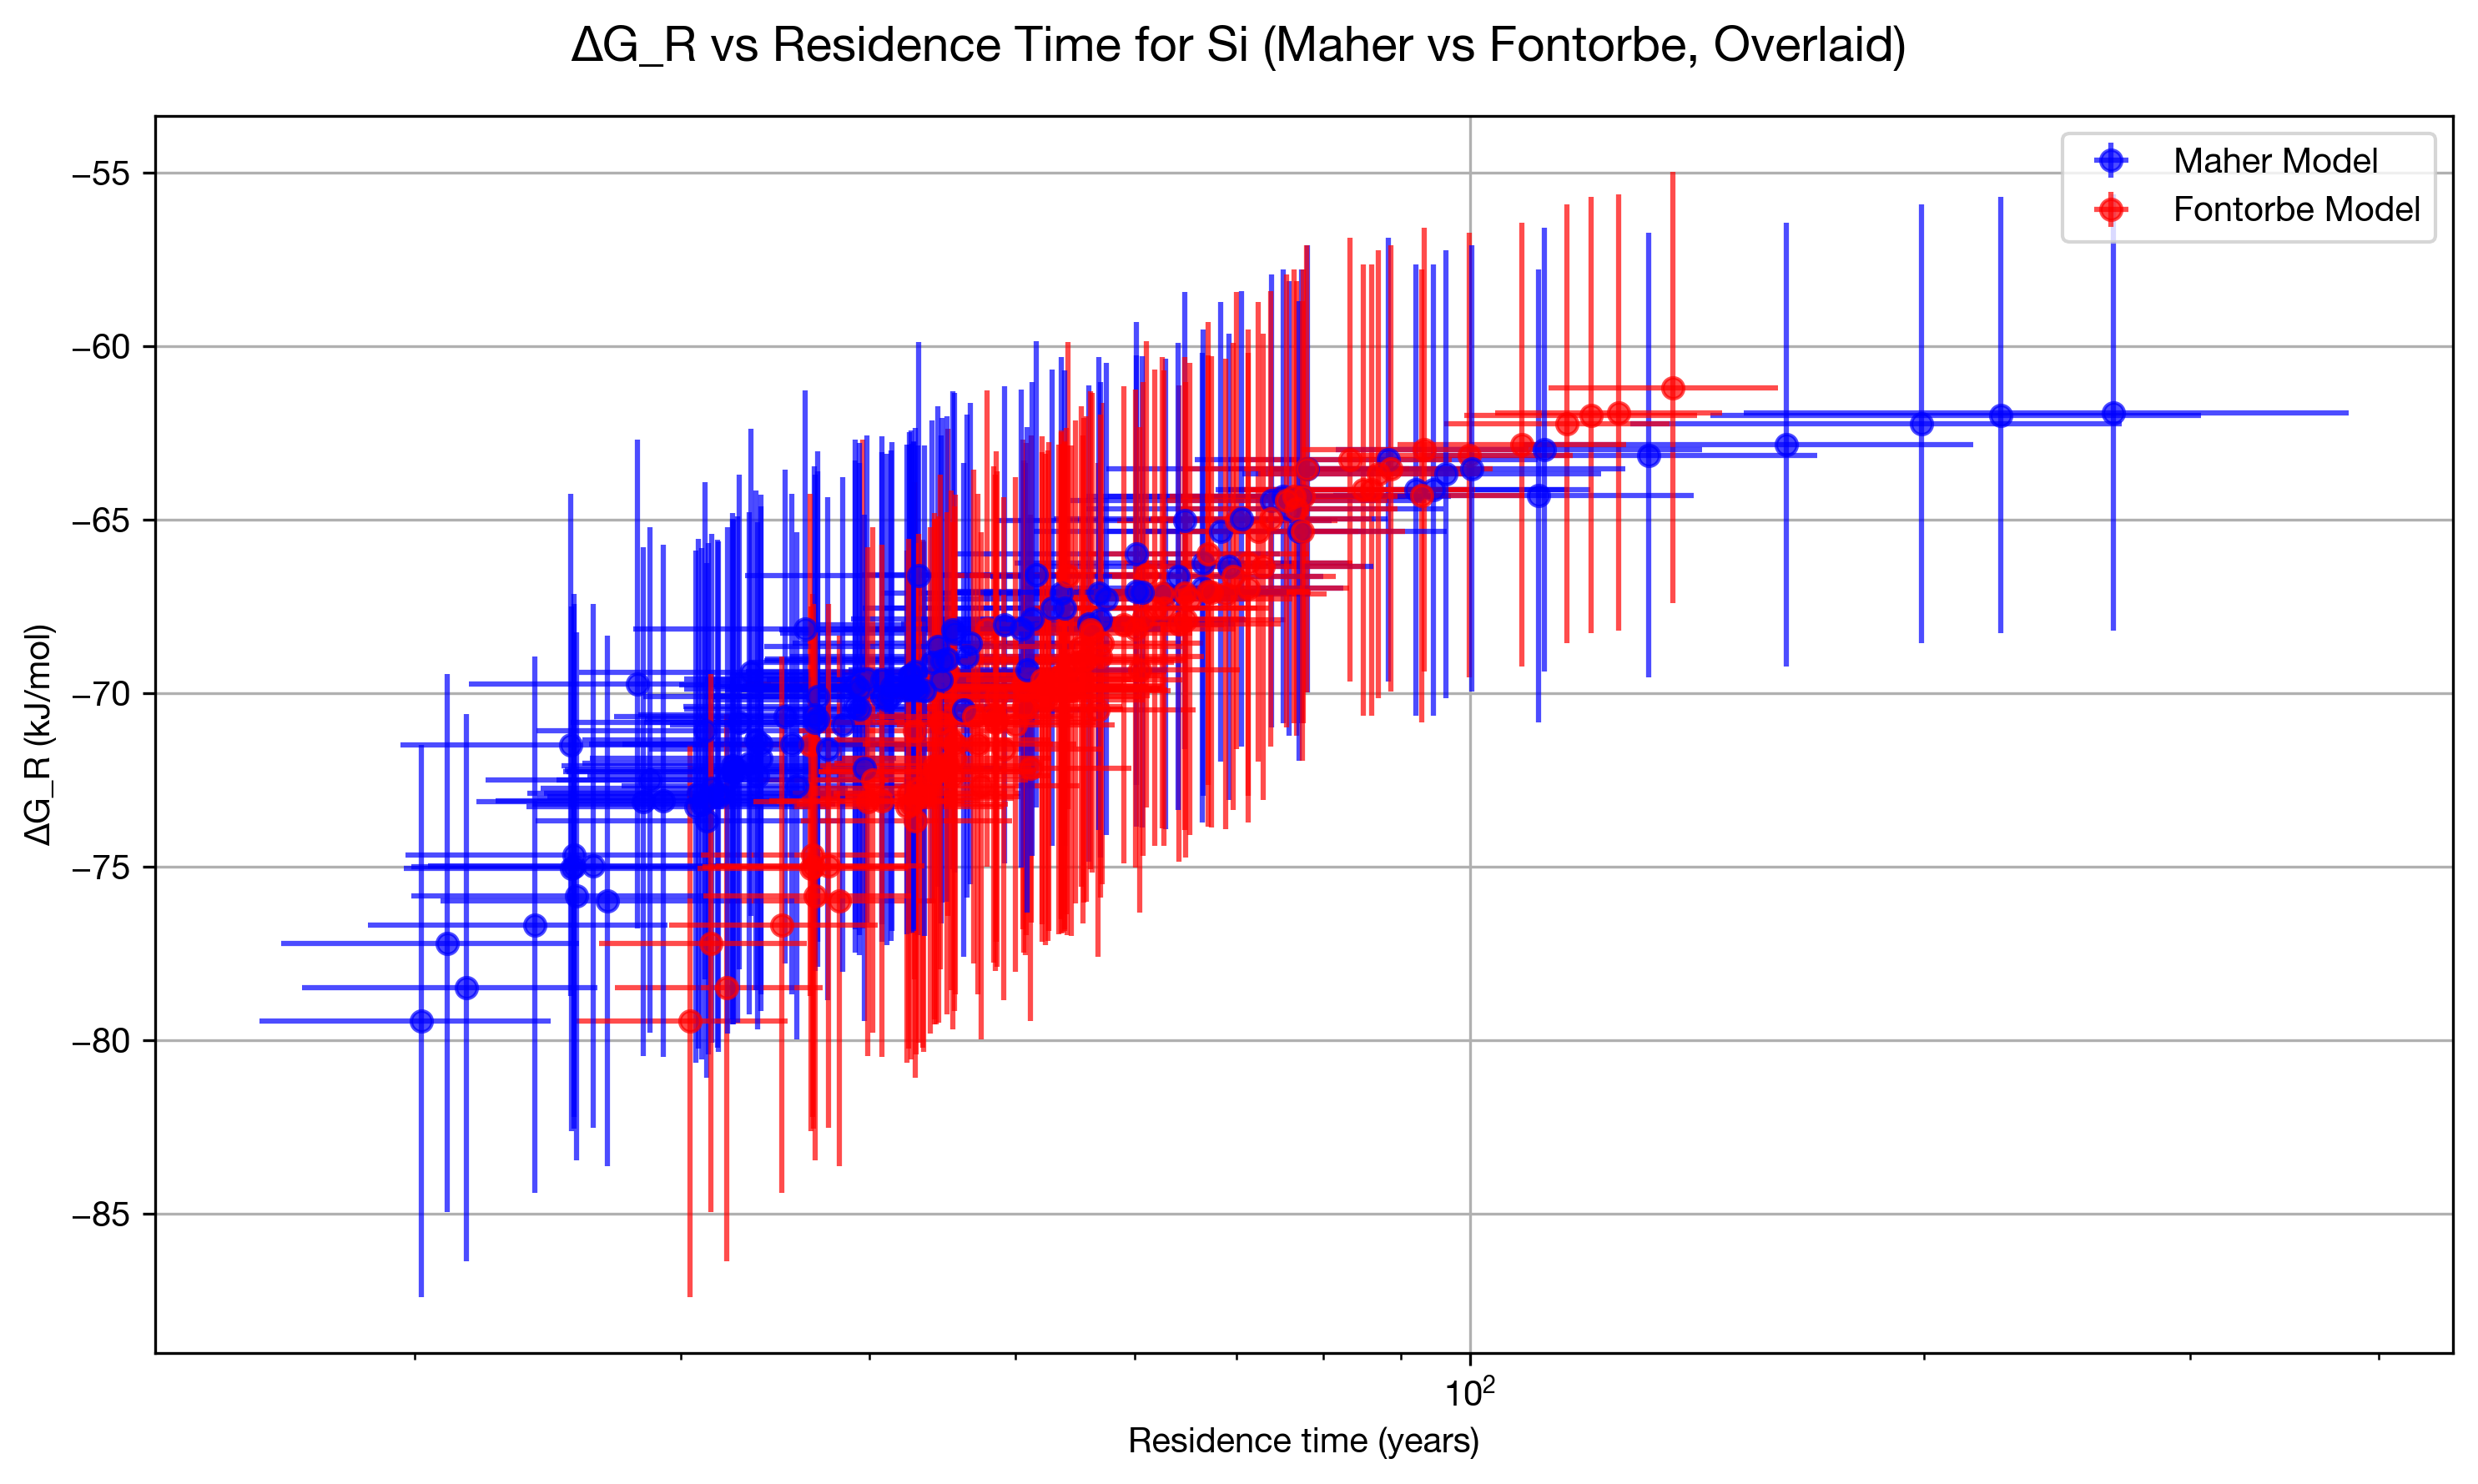

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors and markers for different traverses
traverse_colors = {1: 'blue', 2: 'red', 3: 'blue', 4: 'red', 5: 'blue'}  # Blue for Maher, Red for Fontorbe
markers = {1: 'o', 2: 'o', 3: 'o', 4: 'o', 5: 'o'}  # Same markers

# Create a single figure with one plot overlaying both models
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Loop through each traverse and extract mean/std from df_monte_carlo
for i in range(1, 6):  
    traverse_name = f"Traverse {i}"

    df_traverse_summary = (
        df_monte_carlo[df_monte_carlo["Traverse"] == traverse_name]
        .groupby(["Index", "Sample ID"])  # Keep Sample ID in the index
        .agg({
            "T_res_Maher_Si_uM_EC": ["mean", "std"],
            "T_res_Fontorbe_Si_uM_EC": ["mean", "std"],
            "delta_G_R_kJmol": ["mean", "std"]
        })
        .reset_index()
    )

    # 🔥 Flatten MultiIndex columns
    df_traverse_summary.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_traverse_summary.columns]
    
    # List of Sample IDs to remove
    outliers = ["NEP22-61", "NEP22-62", "NEP24-061", "NEP24-064"]

    # Remove rows where "Sample ID_" matches any in the outliers list
    df_traverse_summary = df_traverse_summary[~df_traverse_summary["Sample ID_"].isin(outliers)]

    # Remove rows where delta_G_R_kJmol_mean has an imaginary part
    df_traverse_summary = df_traverse_summary[df_traverse_summary["delta_G_R_kJmol_mean"].apply(lambda x: np.isreal(x))]

    # Ensure only real values remain
    df_traverse_summary["delta_G_R_kJmol_mean"] = df_traverse_summary["delta_G_R_kJmol_mean"].apply(np.real)

    if df_traverse_summary.empty:
        print(f"⚠️ Warning: No valid data for {traverse_name}")
        continue  # Skip if no data

    # Ensure delta_G_R_kJmol is real-valued
    df_traverse_summary["delta_G_R_kJmol_mean"] = df_traverse_summary["delta_G_R_kJmol_mean"].apply(lambda x: np.real(x))
    df_traverse_summary["delta_G_R_kJmol_std"] = df_traverse_summary["delta_G_R_kJmol_std"].apply(lambda x: np.real(x))

    # Plot Maher model residence time (Blue)
    ax.errorbar(
        df_traverse_summary["T_res_Maher_Si_uM_EC_mean"],
        df_traverse_summary["delta_G_R_kJmol_mean"],
        xerr=df_traverse_summary["T_res_Maher_Si_uM_EC_std"],
        yerr=df_traverse_summary["delta_G_R_kJmol_std"],
        fmt=marker, color="blue", label='Maher Model' if i == 1 else "", alpha=0.7
    )

    # Plot Fontorbe model residence time (Red)
    ax.errorbar(
        df_traverse_summary["T_res_Fontorbe_Si_uM_EC_mean"],
        df_traverse_summary["delta_G_R_kJmol_mean"],
        xerr=df_traverse_summary["T_res_Fontorbe_Si_uM_EC_std"],
        yerr=df_traverse_summary["delta_G_R_kJmol_std"],
        fmt=marker, color="red", label='Fontorbe Model' if i == 1 else "", alpha=0.7
    )

# Set x/y labels
ax.set_xlabel('Residence time (years)')
ax.set_xscale('log')  # Keep log scale for better visualization
ax.set_ylabel('ΔG_R (kJ/mol)')
ax.legend()
ax.grid(True)

# Set overall figure title
fig.suptitle('ΔG_R vs Residence Time for Si (Maher vs Fontorbe, Overlaid)', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.savefig('delta_G_R_Si_time_Maher_vs_Fontorbe_Overlaid.pdf')
plt.show()


# Sr Isotope Monte Carlo

# Plots for Report

For each traverse, plot:
- Si_mM_EC against Elevation
- Na_mM_EC/Si_mM_EC against Elevation coloured by Season
- T_res_Maher_Si_uM_EC and T_res_Fontorbe_Si_uM_EC against Elevation
- Sr87/Sr86 against 1/Sr

The plot should be square and the four plots inside of that should be square too.
The colours used should be black and red in cases where more than one set of points is plotted

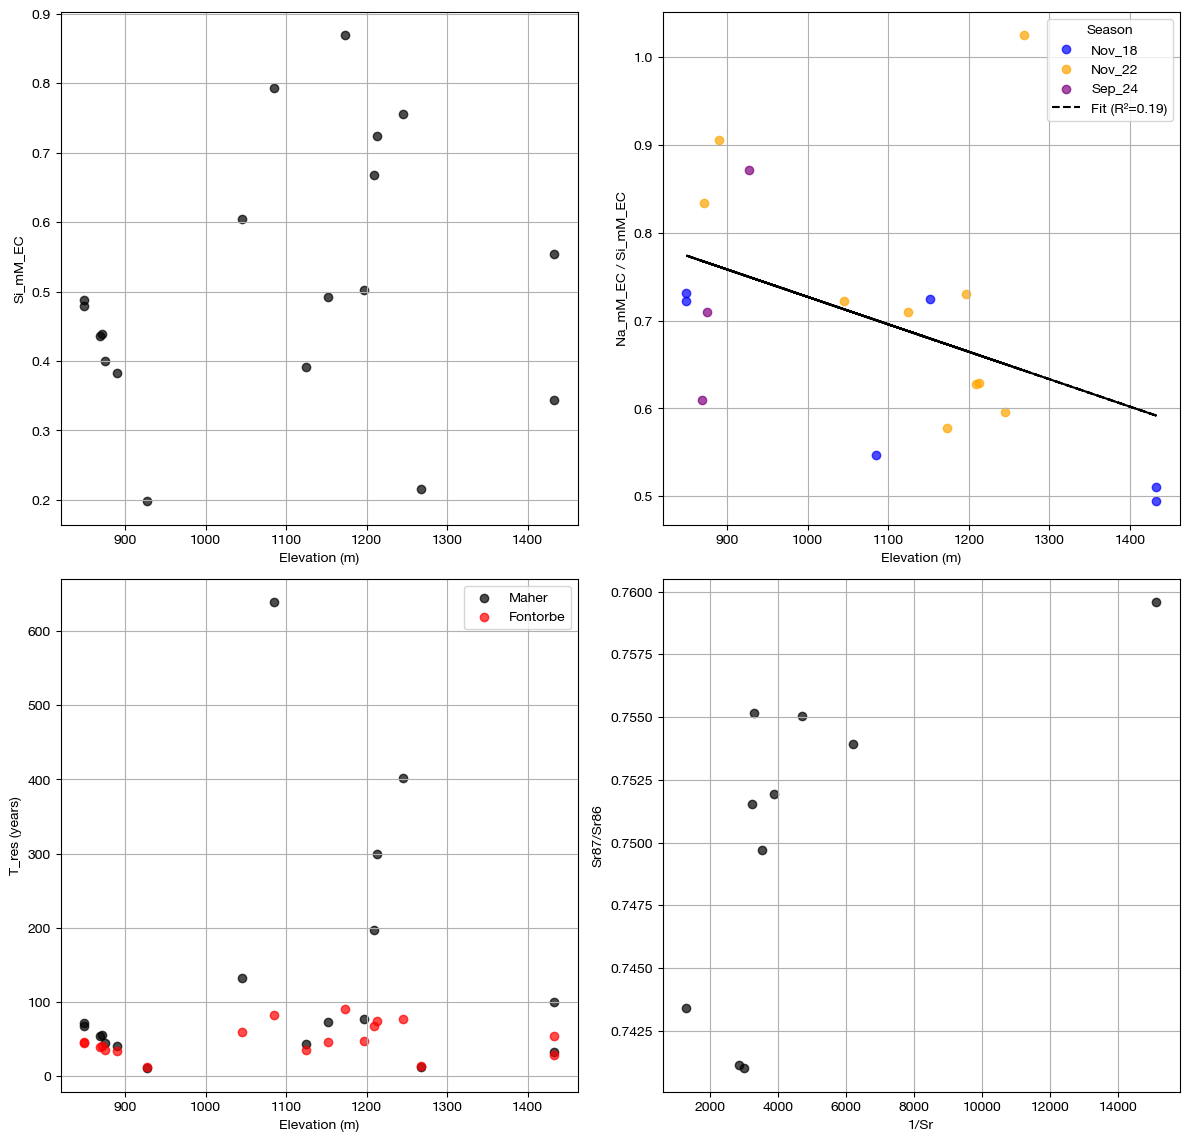

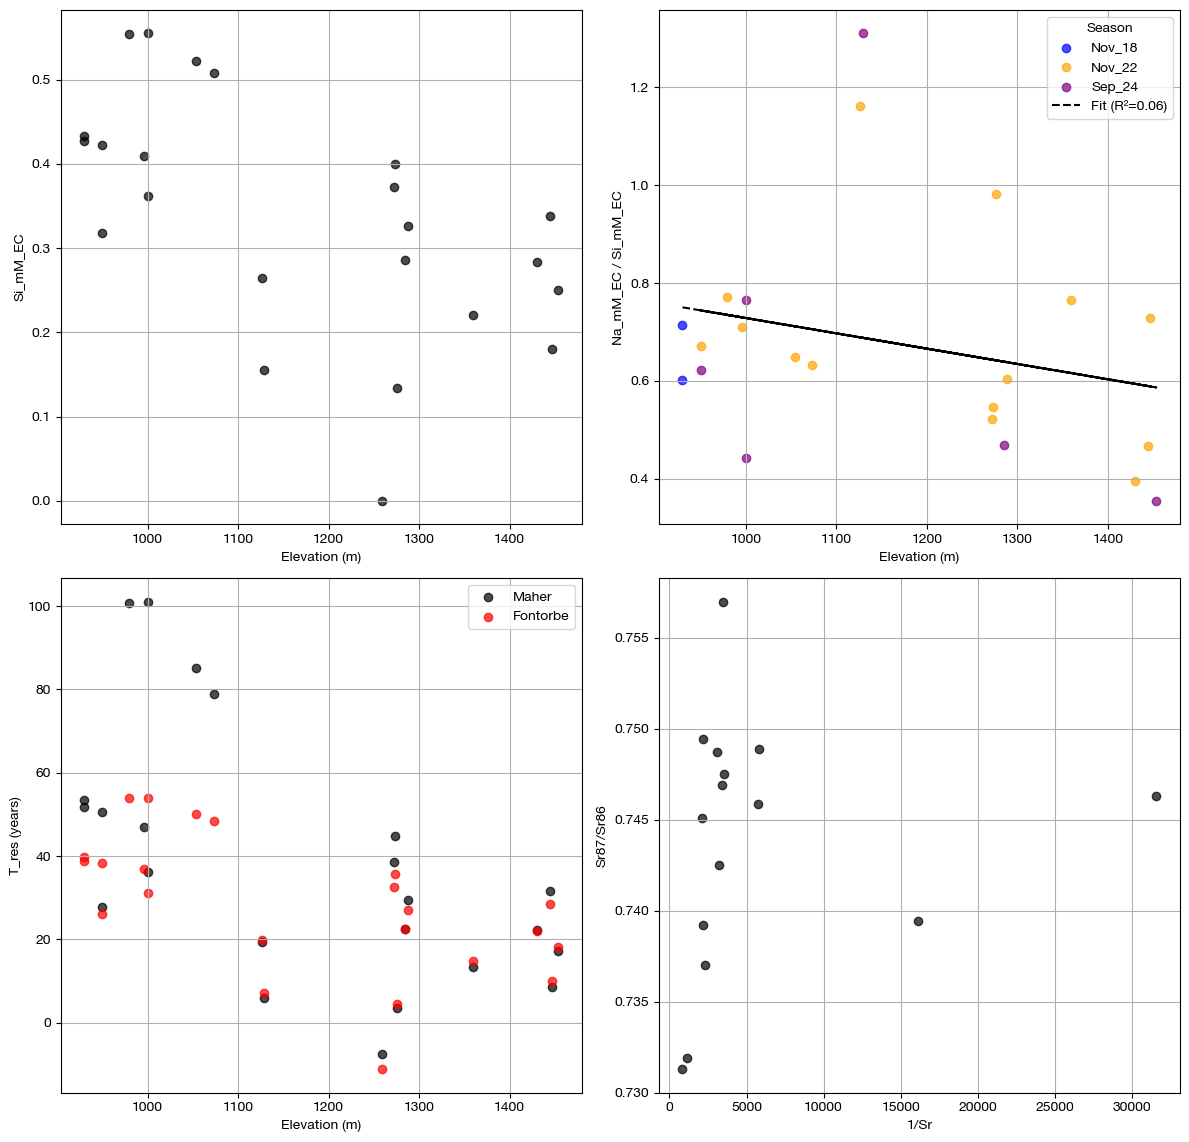

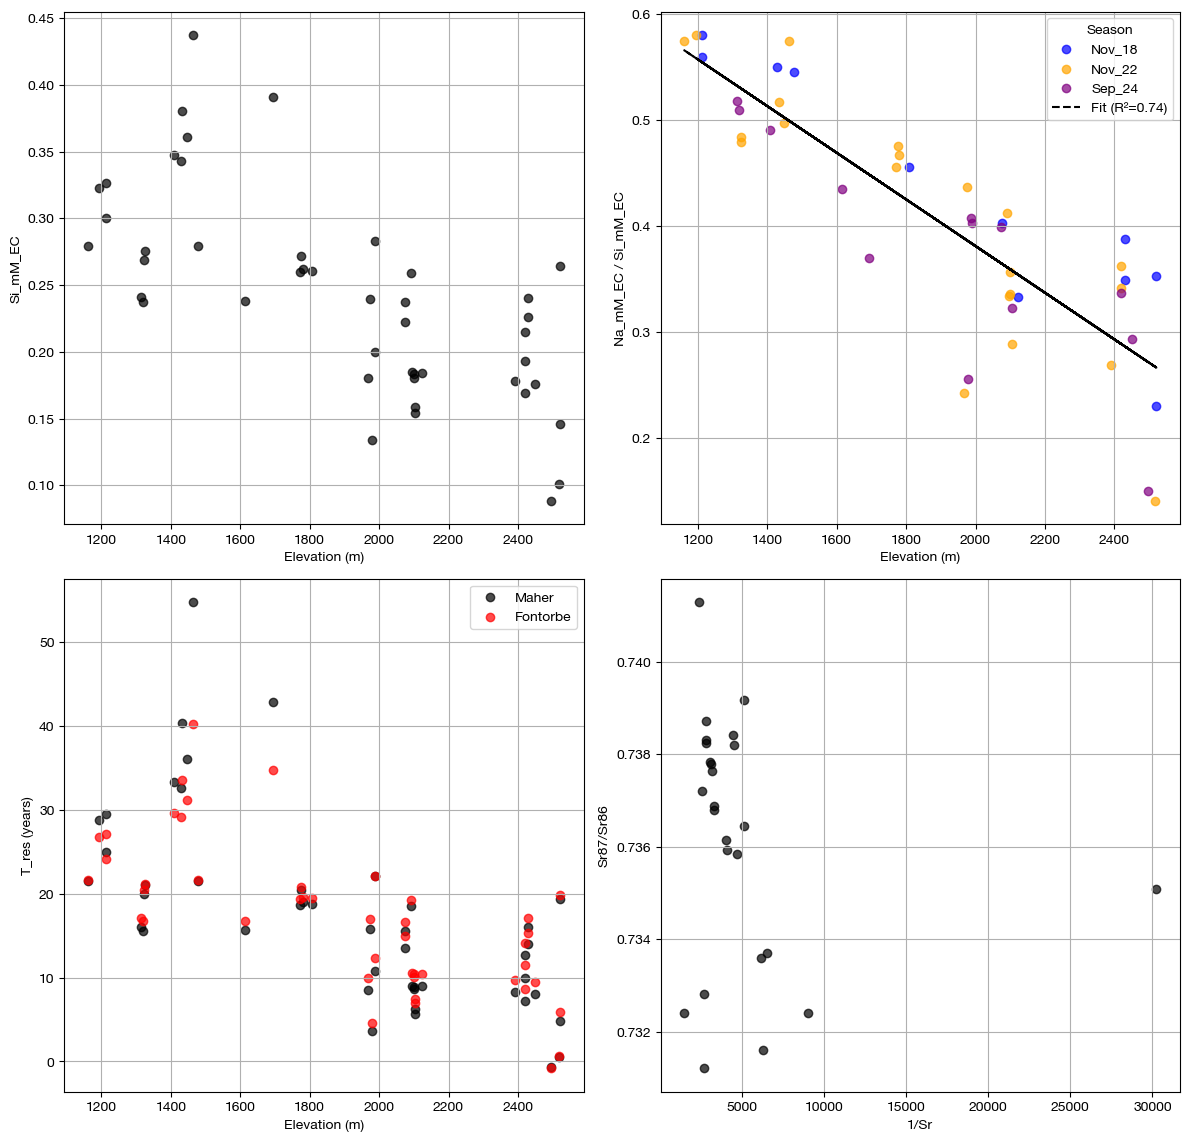

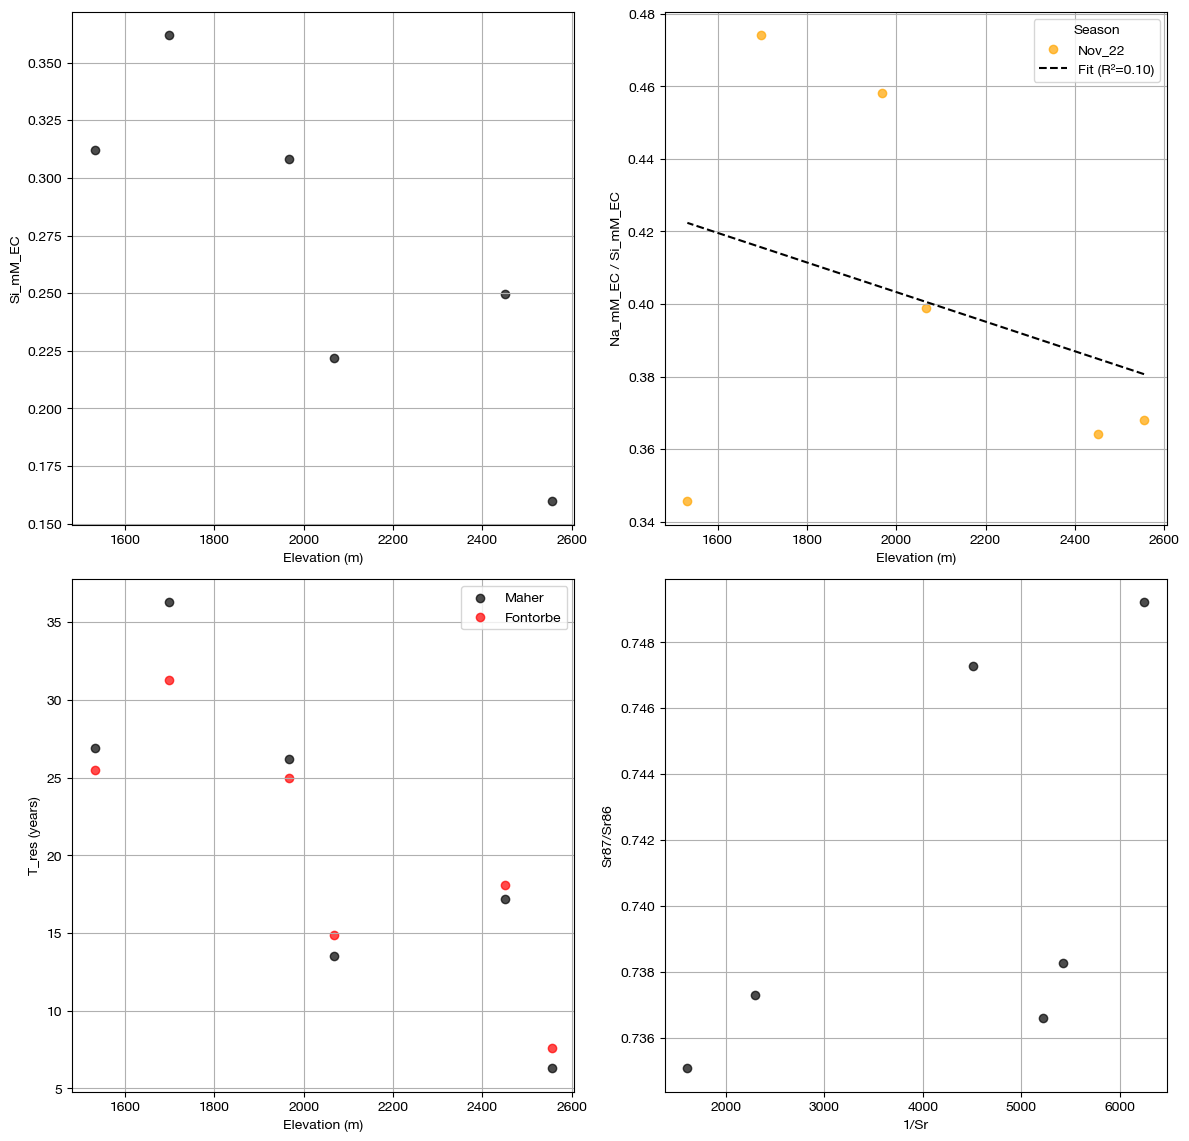

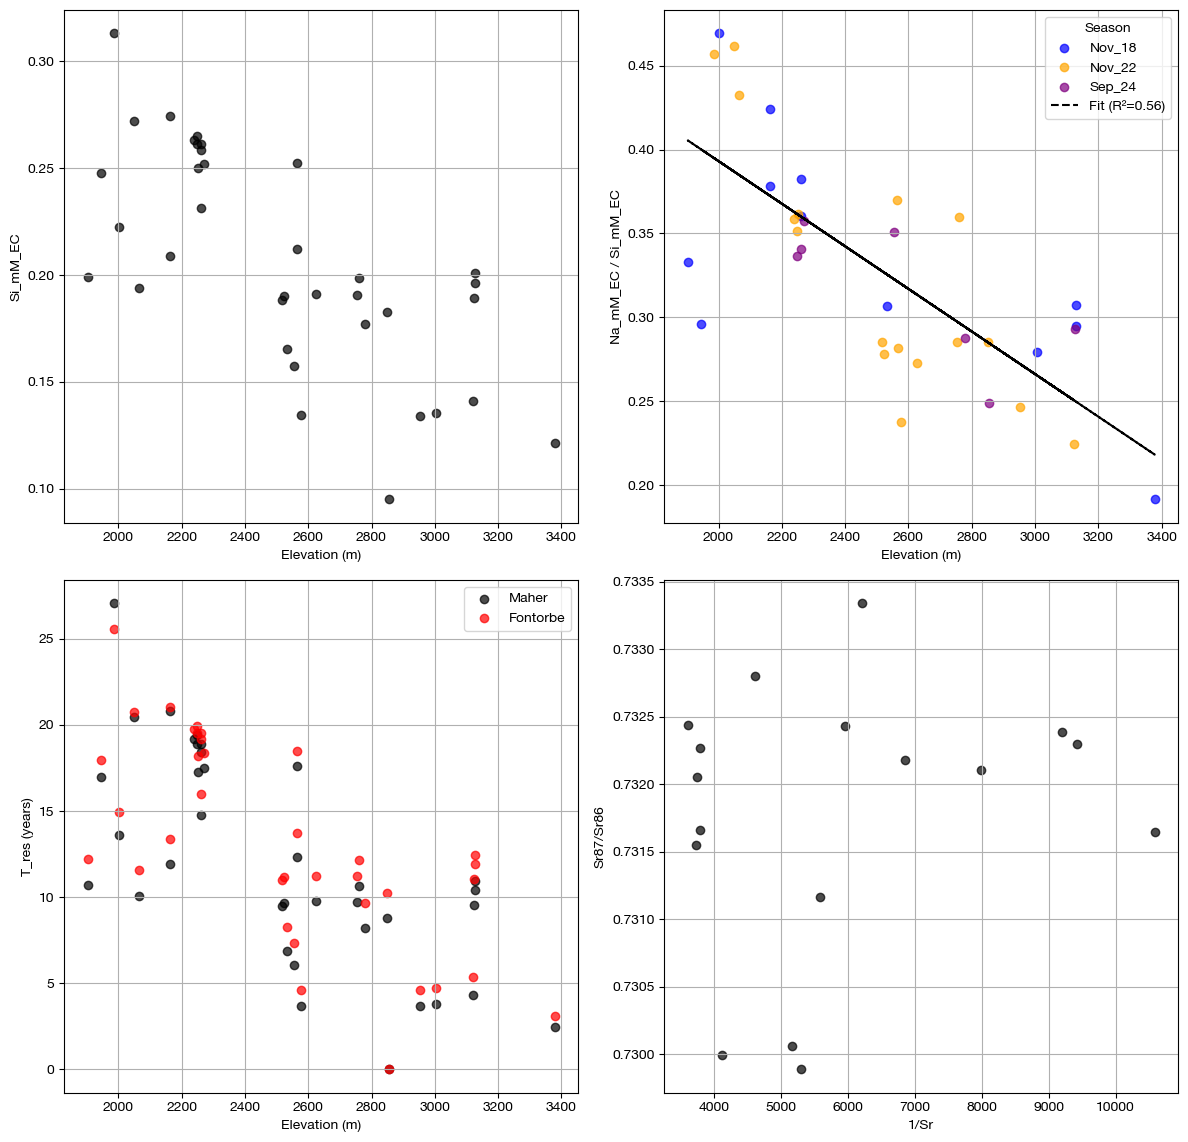

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define colors for seasons
season_colors = {
    'Nov_18': 'blue', 'Nov_22': 'orange', 'Apr_23': 'green', 'Oct_23': 'red', 'Sep_24': 'purple'
}

# Define markers for each season
season_markers = {
    'Nov_18': 'o', 'Nov_22': 'o', 'Apr_23': 'o', 'Oct_23': 'o', 'Sep_24': 'o'
}

show_r2 = True  # Set this to False if you don't want R² to be displayed

# Loop through each traverse
for i in range(1, 6):
    df_name = f"df_traverse{i}"
    df = globals()[df_name]  # Get the actual DataFrame object

    # Define the figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    # Plot Si_mM_EC against Elevation
    axes[0, 0].scatter(df['Elevation'], df['Si_mM_EC'], color='black', alpha=0.7)
    axes[0, 0].set_ylabel('Si_mM_EC')
    axes[0, 0].set_xlabel('Elevation (m)')
    axes[0, 0].grid(True)

    # Plot Na_mM_EC/Si_mM_EC against Elevation colored by Season
    unique_seasons = df['Season'].unique()
    for season in unique_seasons:
        mask = df['Season'] == season
        axes[0, 1].scatter(
            df.loc[mask, 'Elevation'], df.loc[mask, 'Na_mM_EC'] / df.loc[mask, 'Si_mM_EC'],
            color=season_colors.get(season, 'gray'),
            marker=season_markers.get(season, 'x'),
            label=season, alpha=0.7
        )

    # Filter out NaNs and zeros from regression data
    valid_data = df[['Elevation', 'Na_mM_EC', 'Si_mM_EC']].dropna()  # Remove NaN values
    valid_data = valid_data[valid_data['Si_mM_EC'] != 0]  # Avoid division by zero

    if not valid_data.empty:  # Only proceed if there is valid data
        X = valid_data[['Elevation']].values  # Independent variable (2D array)
        y = (valid_data['Na_mM_EC'] / valid_data['Si_mM_EC']).values  # Dependent variable

        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)

        # Plot regression line
        axes[0, 1].plot(valid_data['Elevation'], y_pred, color='black', linestyle='dashed',
                        label=f'Fit (R²={r2:.2f})' if show_r2 else 'Fit')

    axes[0, 1].set_ylabel('Na_mM_EC / Si_mM_EC')
    axes[0, 1].set_xlabel('Elevation (m)')
    axes[0, 1].grid(True)
    axes[0, 1].legend(title="Season", loc='upper right')

    # Plot T_res_Maher_Si_uM_EC and T_res_Fontorbe_Si_uM_EC against Elevation
    axes[1, 0].scatter(df['Elevation'], df['T_res_Maher_Si_uM_EC'], color='black', marker='o', label='Maher', alpha=0.7)
    axes[1, 0].scatter(df['Elevation'], df['T_res_Fontorbe_Si_uM_EC'], color='red', marker='o', label='Fontorbe', alpha=0.7)
    axes[1, 0].set_ylabel('T_res (years)')
    axes[1, 0].set_xlabel('Elevation (m)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot Sr87/Sr86 against 1/Sr
    axes[1, 1].scatter(1 / df['Sr_mM_EC'], df['Sr87/Sr86'], color='black', alpha=0.7)
    axes[1, 1].set_ylabel('Sr87/Sr86')
    axes[1, 1].set_xlabel('1/Sr')
    axes[1, 1].grid(True)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save each figure separately
    plt.savefig(f'Traverse_{i}_summary.pdf')
    plt.show()
